# Data analysis code for the manuscript "Room temperature optomechanical squeezing"

This is an iPython script written in Jupyter notebook with Python 3 (all this software is open source and can be easily installed on any platform.)

This notebook imports the measured data as well as the model. The model has been calculated using a full quantum-optics code written in MATLAB, and it is simply imported here.

The notebook then performs all the necessary analysis to produce the plots informative to understand the data:

- Load and display all measurements required to characterise the system (shot noise, dark noise, cavity loop, homodyne loop, optical spring transfer function, various power levels, visibility and PD gains)
- Average measured shotnoise to a shot noise level, normalize all measured noises to this level
- Load squeezing measurements alongwith respective LO powers. Convert LO powers to quadrature
- Calculate uncertainty in quadrature for shot-noise calibrated measurements
- Obtain feedback noise and differential phase noise
- Load results of MATLAB model (contains thermal noise and quantum noise)
- Perform interpolation of model at the frequencies and quadratures of the measurement
- Add differential phase noise and feedback noise to get total expected noise
- Use difference between measurement and total expected noise to get excess loss
- Add excess loss to the expected noise to obtain total budgeted noise
- Get correlation-calibrated measurement of squeezing
- Calculate uncertainty in quadrature for correlation calibrated measurements
- Perform comparison of correlation-calibrated measurement with shot-noise calibrated measurement
- Infer the relative quadrature difference between the two calibrations

Plot everything:

- The quantities obtained after the above steps are then plotted. Most plotting code is self-explanatory.
- Some plots are made at a specific quadrature or frequency. This can be changed by changing to a quadrature or frequency of interest.
- The plots were exported by the plt.savefig command in each cell for the manuscript and presentations. That command can slow down the computation (because I use a high dpi), so it has been put inside an if statement which is set by the boolean variable called save_figures. Initially, this variable has been set to False.

Enjoy!


# Initialize

In [1]:
#% matplotlib inline
import glob
import numpy as np
import re
import matplotlib.colors as col
import matplotlib.pyplot as plt
import pandas as pd

from scipy.io import loadmat

from scipy.interpolate import interp1d
from scipy.interpolate import interp2d

import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import os

In [2]:
# font = {
#        'weight' : 'normal',
#        'size'   : 16}

# plt.rc('font', **font)
#plt.rcParams.update({'font.size': 18})
#plt.rcParams

plt.rcParams
q = mpl.rc_params_from_file('matplotlibrc_dark')
mpl.rcParams.update(q)
%matplotlib inline

In [3]:
plt.rcParams.update({'font.size': 12})

In [4]:
plt.rcParams['font.size']

12.0

In [5]:
# Set this flag to false to run the notebook quickly.
# Set it to true to save all plots to SaveDirFig
# If one particular figure is desired, go to the code block of that figure and toggle the if statement there.

is_script = False
save_figures = True
save_data = False

# SaveDirData = '../Results/temp/Data/'
# SaveDirFig = '../Results/temp/DarkFigures/'

SaveDirFig = '../Results/DarkBGFigs/'

if save_figures:
    if not os.path.exists(SaveDirFig):
        os.makedirs(SaveDirFig)
if save_data:
    if not os.path.exists(SaveDirData):
        os.makedirs(SaveDirData)

# Setup

## Functions

###  function to calculate measurement quadrature

In [6]:
#######################################################
# Define function to calculate measurement quadrature #
#######################################################


def phi(CavPower,LOPower,TotalPower,Visibility,DV):
    i=0
    phi_array = []
    MM_t = Visibility
    Ecav = np.sqrt(CavPower-DV)
    ETotal = np.sqrt(TotalPower-DV)
    
    LOPower_array = np.atleast_1d(LOPower)
    
    for i in np.arange(len(LOPower_array)):
        if LOPower_array[i]==0:
            phi_array.append(0)            
        else:
            ELO = np.sqrt(LOPower_array[i]-DV)*MM_t
            costheta = (ETotal**2 - ELO**2 - Ecav**2)/(2*Ecav*ELO)
#             costheta =(TotalPower+DV-CavPower-LOPower_array[i])/(2*MM_t*Ecav*ELO)
            theta = np.arccos(costheta)
            E_Y = ELO*np.sin(theta)
            E_X = Ecav + ELO*np.cos(theta)
#             E_Y = ELO*np.sin(theta)*MM_t
#             E_X = Ecav+ELO*np.cos(theta)*MM_t
    
            phi = np.arctan(E_Y/E_X)
            phi_array.append(phi*180/np.pi)
    phi_array=np.array(phi_array)        
    return phi_array
# print(phi(np.array(1.29),np.array(.1),np.array(1.1),.95,.7e-3))
# print(phi(np.array(1.29*.98),np.array(.1*.98),np.array(1.1*.98),.95,.7e-3))

### Define other basic functions

In [7]:
applyloss = lambda n,loss: (n*(1-loss)+loss) # this function takes a noise in PSD, applies loss, and spits out final PSD. 
# This is valid for use in quantum noise or total noise. Not to be used for individual classical noise components 

dBToPSD = lambda ndB:10**(ndB/10) 

PSDTodB = lambda nPSD: 10*np.log10(nPSD)


## Experimental parameters

### Frequencies of interest

In [8]:
f_interest_low_kHz = 20
f_interest_high_kHz = 80


### Measured

In [9]:
# various power levels measured in the lab

CavPower = 1.29 # cavity power on transmision, ie signal power (E_s in Fig 8)
TotalPower = 1.1 # power of resultant (E_sqz in Fig 8)
Visibility = .93 # this goes into the calculation of phi for given power measurements
DV = 7e-3 # dark volts on PD_sqz

# BS1 is not included in the mode, so it must be added here. 
# Since it contributes as a simple loss, it can be added in post-processing of the results from the model.
BS1_Loss         = 0.15; 

PD_Transimpedance = 30e3; # Ohms
PD_Responsivity_with_QE = .742#0.6; # Amps/Watts
PathEfficiency = .965*.85*.94 


### Calculate power in $P_S$ and $P_{sqz}$ from PD properties

In [10]:

P_S = (CavPower-DV)/(PD_Responsivity_with_QE*PD_Transimpedance)
print("Cavity power after BS1 is {:.1f} uW".format( P_S*1e6 ))

P_sqz = (TotalPower-DV)/(PD_Responsivity_with_QE*PD_Transimpedance)
print("Power after BS2 is {:.1f} uW".format( P_sqz*1e6 ))


print("Total efficiency is {:.1f}".format(PathEfficiency))
P_Trans_min = P_S/PathEfficiency
print("Cavity transmitted power  {:.1f} uW" .format(P_Trans_min*1e6))

P_Cav_min = P_Trans_min/(250e-6)
print("Cavity power {:.1f} mW" .format(P_Cav_min*1e3))

Cavity power after BS1 is 57.6 uW
Power after BS2 is 49.1 uW
Total efficiency is 0.8
Cavity transmitted power  74.8 uW
Cavity power 299.0 mW


## Various feedback loops

### Load OS measurement

In [11]:
OSfile = '../Measurements/main_measurements/Current_OS/Data.csv'

In [12]:
OS_meas_f=pd.read_csv(OSfile,usecols=[1],header=None)
OS_meas_Amp=pd.read_csv(OSfile,usecols=[7],header=None)
OS_meas_Phase=pd.read_csv(OSfile,usecols=[8],header=None)

### Load Homodyne Loop TF

In [13]:
HomodyneLoopfile = '../Measurements/quadrature_locking_loop_OLG_30k-100k/Data.csv'
HomodyneLoop_f = pd.read_csv(HomodyneLoopfile,usecols=[1],header=None)
HomodyneLoop_Amp = pd.read_csv(HomodyneLoopfile,usecols=[7],header=None)
HomodyneLoop_Phase = pd.read_csv(HomodyneLoopfile,usecols=[8],header=None)


### Load Cavity loop TF

In [14]:
CavityOLGfile = '../Measurements/open_loop_main_locking/Data.csv'
CavityOLG_f = pd.read_csv(CavityOLGfile,usecols=[1],header=None)
CavityOLG_Amp = pd.read_csv(CavityOLGfile,usecols=[7],header=None)
CavityOLG_Phase = pd.read_csv(CavityOLGfile,usecols=[8],header=None)

In [15]:
#SaveDirFig = SaveDirFig_0 + 'BS1_Loss_%0.0f/' %(BS1_Loss*100)
#print(SaveDirFig)
#import os
#if not os.path.exists(SaveDirFig):
#    os.makedirs(SaveDirFig)

## Shot Noise, RIN and dark noise data

### Load files

In [16]:
RINfile = '../Measurements/classical_RIN/RIN_Cross_Spectrum_amp.dat'
RINDClevel = 4.8 # Volts
RINdata = np.loadtxt(RINfile) # gives freq and powerspec
ClassicalNoise = np.sqrt(RINdata[:,1])*TotalPower/RINDClevel # Get the contribution of RIN in the squeezing measurement

DNfile = '../Measurements/SN_measure/darknoise_new.dat'
DNdata=np.loadtxt(DNfile) # gives freq and amp spec

SNfile = '../Measurements/Shot_Noise_Remeasure/25k_ave/1100mV_LO_.dat'
SNdata = np.loadtxt(SNfile) # gives freq and amp spec
#SNlevel = np.mean(SNData[:,1])
#SN_level_old = 1.47e-6 # this is the reference used in the measurement of squeezing before

### Average Shot Noise over frequencies

In [17]:
## Average shot noise between 20 kHz and 100 kHz because lower frequency measurement was contaminated with other stuff
f_low_SN_kHz = 20
ind_f_low_SN = (np.abs(SNdata[:,0]-f_low_SN_kHz*1e3)).argmin()

f_high_SN_kHz = 100
ind_f_high_SN = (np.abs(SNdata[:,0]-f_high_SN_kHz*1e3)).argmin()

In [18]:
SN_level = np.mean(SNdata[ind_f_low_SN:ind_f_high_SN,1]) # average shot noise between 20 and 100 kHz
print('Average shot noise level for measurements at 1.1 V DC power: {} V'.format(SN_level))

Average shot noise level for measurements at 1.1 V DC power: 1.46328510528e-06 V


### Amplitude quadrature was measured with no LO, hence shot noise can be rescaled to just Cavity Power

In [19]:
SN_level_0 = SN_level*np.sqrt((CavPower-DV)/(TotalPower-DV))
print('Average shot noise level for amplitude quadrature measurement (1.29 V DC power): {} V'.format(SN_level_0))

Average shot noise level for amplitude quadrature measurement (1.29 V DC power): 1.5853757071131117e-06 V


### normalize using the average and convert to dBs

In [20]:
# As opposed to all the other noises, RIN was measured in V/rt Hz so we need a shot noise in V/rtHz to normalize RIN
SN_level_V_per_rtHz = SN_level/np.sqrt(192) 
print('Average shot noise level ASD: {} V/rtHz'.format(SN_level_V_per_rtHz))

SNdB = PSDTodB((SNdata[:,1]/SN_level)**2)
RINdB = PSDTodB((ClassicalNoise/SN_level_V_per_rtHz)**2)
DNdB = PSDTodB((DNdata[:,1]/SN_level)**2)


Average shot noise level ASD: 1.0560350617932224e-07 V/rtHz


# Load main noise measurements

## Squeezing Measurement

### Load files

In [21]:
# Find files containing spectra
data_pos = '../Measurements/main_measurements/Positive/' # folder containing data for positive quadratures
data_neg = '../Measurements/main_measurements/Negative/' # folder containing data for negative quadratures

list_dir_pos = glob.glob(data_pos+'*/*FFT1.dat') # Find all filenames that end in 'FFT1.dat', put their directory in a list
list_dir_neg = glob.glob(data_neg+'*/*FFT1.dat') # Find all filenames that end in 'FFT1.dat', put their directory in a list

#Sort directories by numerical value (LO power)
list_dir_pos.sort(key= lambda d: int("".join(filter(str.isdigit, d)))) # the directories have LO power in their name
list_dir_neg.sort(key=lambda d: int("".join(filter(str.isdigit, d))))


##########################################################
# Manage files and datas                                 #
#  -Find numerical value before "mv" and append to array #
#  -Get spectrum at each LO power from data              #
#  -Get phi for each LO power from phi function          #
##########################################################


##############################
# First positive quadratures
##############################

LOPOWER_ARRAY_POS = []
spec = np.zeros((len(list_dir_pos)+len(list_dir_neg)-1,801))
coherence = np.zeros((len(list_dir_pos)+len(list_dir_neg)-1,801))
ii = 0
for _file_ in list_dir_pos:
    LO = re.findall(r"(\d+)mV", _file_)
    LOPower = float(LO[0])*1e-3
    LOPOWER_ARRAY_POS.append(LOPower)
    FFT_filename = str(_file_)
    data = np.loadtxt(FFT_filename)
    Coherence_filename = FFT_filename
    Coherence_filename = Coherence_filename.replace("FFT1","Coherence")
    data_coherence  = np.loadtxt(Coherence_filename)
    if ii == 0:
        f_meas = data[:,0]    
    if LOPower==0:
        data_pos_0deg = data[:,1]*SN_level/SN_level_0
        spec[ii] = data[:,1]*SN_level/SN_level_0 ## amplitude quadrature has a different shot noise
    else:
        spec[ii] = data[:,1]
    coherence[ii] = data_coherence[:,1]
    ii+=1
LOPOWER_ARRAY_POS = np.array(LOPOWER_ARRAY_POS)

##############################
# Negative Quadratures
##############################

LOPOWER_ARRAY_NEG = []
for i in np.arange(len(list_dir_neg)):
    LO = re.findall(r"(\d+)mV", data_neg+list_dir_neg[i])
    LOPower = float(LO[0])*1e-3
    LOPOWER_ARRAY_NEG.append(LOPower)
    FFT_filename = str(list_dir_neg[i])
    data = np.loadtxt(FFT_filename)
    Coherence_filename = FFT_filename
    Coherence_filename = Coherence_filename.replace("FFT1","Coherence")
    data_coherence  = np.loadtxt(Coherence_filename)
    if LOPower==0:
        data_neg_0deg = data[:,1]*SN_level/SN_level_0
    else:
        spec[ii] = data[:,1]
        coherence[ii] = data_coherence[:,1]
        ii+=1
        
LOPOWER_ARRAY_NEG = np.array(LOPOWER_ARRAY_NEG)
# print(LOPOWER_ARRAY_NEG)



### Get calibrated $\phi$

In [22]:
phi_pos = phi(CavPower,LOPOWER_ARRAY_POS,TotalPower,Visibility,DV)
phi_neg = -phi(CavPower,LOPOWER_ARRAY_NEG,TotalPower,Visibility,DV)
# print(LOPOWER_ARRAY_POS)
# print(phi_pos)
phi_all = np.concatenate([phi_pos,phi_neg[1:len(phi_neg)]])
print('Measurement quadratures in degrees: {}'.format(phi_all))


Measurement quadratures in degrees: [  0.           5.83799447  10.3086804   12.43145439  14.24542712
  15.85695446  17.32265004  18.67689785  23.86902354  34.59593032
  40.43914639  -9.06516424 -26.33525574 -40.72860761]


### Sort $\phi$ in increasing order, sort the squeezing measurement to go with it.

In [23]:
# Need to sort phi_all in increasing order to fix the next plot, and then get spec to sort according to phi_all
phi_all_sort_index = phi_all.argsort()
phi_sorted  = phi_all[phi_all_sort_index]
spec_sorted_Volts = spec[phi_all_sort_index,:]
coherence_sorted = coherence[phi_all_sort_index,:]

print(phi_sorted)

[-40.72860761 -26.33525574  -9.06516424   0.           5.83799447
  10.3086804   12.43145439  14.24542712  15.85695446  17.32265004
  18.67689785  23.86902354  34.59593032  40.43914639]


In [24]:
P_LO = (LOPOWER_ARRAY_POS-DV)/(PD_Responsivity_with_QE*PD_Transimpedance)
print("Positive quadratures: ",np.around(phi_pos))
print("Positive quadratures LO Powers in mV: ",np.around(LOPOWER_ARRAY_POS*1e3))
print("Positive quadratures LO Powers in uW: ",np.around(P_LO*1e6))

P_LO = (LOPOWER_ARRAY_NEG-DV)/(PD_Responsivity_with_QE*PD_Transimpedance)
print("Negative quadratures: ",np.around(phi_neg))
print("Negative quadratures LO Powers in mV: ",np.around(LOPOWER_ARRAY_NEG*1e3))
print("Negative quadratures LO Powers in uW: ",np.around(P_LO*1e6))

Positive quadratures:  [ 0.  6. 10. 12. 14. 16. 17. 19. 24. 35. 40.]
Positive quadratures LO Powers in mV:  [  0.  30.  60.  80. 100. 120. 140. 160. 250. 500. 670.]
Positive quadratures LO Powers in uW:  [-0.  1.  2.  3.  4.  5.  6.  7. 11. 22. 30.]
Negative quadratures:  [ -0.  -9. -26. -41.]
Negative quadratures LO Powers in mV:  [  0.  50. 300. 679.]
Negative quadratures LO Powers in uW:  [-0.  2. 13. 30.]


### Calculate errorbars in the squeezing quadrature inference

Quadrature angle ranges based off possible PD voltage measurement. 

#### Use uncertainty in cavity power and LO power

In [25]:
LO_power_sqz_quad = LOPOWER_ARRAY_POS[np.abs(phi_pos-12).argmin()]

In [26]:

cav_power_error = 0.05
LO_power_error = 0.05
cav_power_array = CavPower*np.arange(1-cav_power_error,1+cav_power_error,cav_power_error/10)
LO_power_array = LO_power_sqz_quad*np.arange(1-LO_power_error,1+LO_power_error,LO_power_error/10)
w = len(LO_power_array)
h = len(cav_power_array)

phi_matrix_1 = [[0 for x in range(w)] for y in range(h)] 


for i in np.arange(len(cav_power_array)):
    for j in np.arange(len(LO_power_array)):
        phi_matrix_1[i][j]=phi(cav_power_array[i],LO_power_array[j],TotalPower,Visibility,DV)[0]



# plt.contourf(LO_power,cav_power,Matrix)
# plt.ylabel('P_Cav (Volts)')
# # plt.yticks((1.19,1.24,1.29,1.34,1.39))
# plt.xlabel('P_LO (Volts)')
# plt.colorbar()
# plt.title('Measurement quadrature as a function of\n LO power and cavity power (degrees)')
# plt.show()


In [27]:
print('Squeezing quadrature range for shot-noise calibrated measurement is ({:0.1f} ,{:0.1f}) degrees if error in measuring cavity power and LO power is taken into account.'
      .format(np.array(phi_matrix_1).min(),np.array(phi_matrix_1).max()))

Squeezing quadrature range for shot-noise calibrated measurement is (11.2 ,13.4) degrees if error in measuring cavity power and LO power is taken into account.


#### Add error in total power

In [28]:
Total_power_error  = 0.05
Total_power_array = np.arange(1-Total_power_error,1+Total_power_error,Total_power_error/10)*TotalPower
w = len(LO_power_array)
h = len(cav_power_array)
d = len(Total_power_array)

phi_matrix_2 = [[[0 for x in range(w)] for y in range(h)] for z in range(d)]

for k in np.arange(len(Total_power_array)):
    for i in np.arange(len(cav_power_array)):
        for j in np.arange(len(LO_power_array)):
            phi_matrix_2[k][i][j]=phi(cav_power_array[i],LO_power_array[j],Total_power_array[k],Visibility,DV)[0]

# plt.contourf(LO_power,cav_power,Matrix[int((0))])
# plt.ylabel('P_Cav (Volts)')
# # plt.yticks((1.19,1.24,1.29,1.34,1.39))
# plt.xlabel('P_LO (Volts)')
# plt.colorbar()
# plt.show()

In [29]:
print('Quadrature range for shot-noise calibrated measurement is ({:0.1f} ,{:0.1f}) degrees if the error in total power is also taken into account along with cavity power and LO power.'
      .format(np.array(phi_matrix_2).min(),np.array(phi_matrix_2).max()))
print('Keep in mind that the fact that the numerical model predicts the squeezing quadrature and thermal noise cancellation quadrature for the detuning puts constraints on the quadrature that are not taken into account in these error bars')

Quadrature range for shot-noise calibrated measurement is (10.5 ,13.5) degrees if the error in total power is also taken into account along with cavity power and LO power.
Keep in mind that the fact that the numerical model predicts the squeezing quadrature and thermal noise cancellation quadrature for the detuning puts constraints on the quadrature that are not taken into account in these error bars


#### What happens for other angles

C:\Users\Nancy\Anaconda2\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in arccos


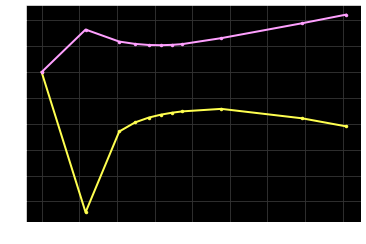

In [30]:
phi_pos_min = []
phi_pos_max = []
for phi_ii in phi_pos:
    LO_power_arb_quad = LOPOWER_ARRAY_POS[np.abs(phi_pos-phi_ii).argmin()]
    phi_SN = phi_pos[np.abs(phi_pos-phi_ii).argmin()]


    cav_power_array = CavPower*np.arange(1-cav_power_error,1+cav_power_error,cav_power_error/10)
    LO_power_array = LO_power_arb_quad*np.arange(1-LO_power_error,1+LO_power_error,LO_power_error/10)
    w = len(LO_power_array)
    h = len(cav_power_array)

#     phi_matrix_1 = [[0 for x in range(w)] for y in range(h)] 
#     for i in np.arange(len(cav_power_array)):
#         for j in np.arange(len(LO_power_array)):
#             phi_matrix_1[i][j]=phi(cav_power_array[i],LO_power_array[j],TotalPower,Visibility,DV)[0]


#     phi_pos_min.append(np.array(phi_matrix_1).min())
#     phi_pos_max.append(np.array(phi_matrix_1).max())

    Total_power_array = np.arange(1-Total_power_error,1+Total_power_error,Total_power_error/10)*TotalPower
    w = len(LO_power_array)
    h = len(cav_power_array)
    d = len(Total_power_array)

    phi_matrix_2 = [[[0 for x in range(w)] for y in range(h)] for z in range(d)]
    for k in np.arange(len(Total_power_array)):
        for i in np.arange(len(cav_power_array)):
            for j in np.arange(len(LO_power_array)):
                phi_matrix_2[k][i][j]=phi(cav_power_array[i],LO_power_array[j],Total_power_array[k],Visibility,DV)[0]

    phi_pos_min.append(np.nanmin(np.array(phi_matrix_2)))
    phi_pos_max.append(np.nanmax(np.array(phi_matrix_2)))

    
plt.figure()
plt.plot(phi_pos,phi_pos_min-phi_pos,phi_pos,phi_pos_max-phi_pos,marker='.')
plt.grid()
# plt.xlim(10,15)
# plt.ylim(-3,2)

### Normalize measured squeezing to shotnoise

In [31]:
# now normalize to shot noise
spec_sorted=spec_sorted_Volts/SN_level

## Measured phase and  feedback Noise

### Get feedback noise

In [32]:
# get feedback noise from coherence data
Feedback_Noise_meas_PSD = coherence_sorted*spec_sorted**2 

# This is already normalized because we used normalized spectra.

In [33]:
## Use the feedback noise at 12 degrees  and scale it by quadrature)

# Coherence_At_12_deg = np.loadtxt('../Data/remeasure_quadrature_new_setup/Positive/80mV/80mV_LO_Coherence.dat')
# Noise_At_12_deg = np.loadtxt('../Data/remeasure_quadrature_new_setup/Positive/80mV/80mV_LO_FFT1.dat')

# Feedback_Noise_PSD_At_12_deg = Coherence_At_12_deg[:,1]*Noise_At_12_deg[:,1]**2/SN_level**2
# Feedback_Noise_PSD_Max = Feedback_Noise_PSD_At_12_deg/(np.cos(np.pi/2+((phi_No_X-12)*np.pi/180))**2)


## Post-note: This method was rejected because it doesn't take into account that feedback noise might be different
# in ways other than simple scaling. So instead, the coherence measurement at each quadrature is a better way to estimate 
# feedback noise.

### Get differential phase noise

In [34]:
phi_No_X = 17; # 17 degrees is the quadrature where we should only have shotnoise. All excess noise in that quadrature must be due to differential phase noise
ind_phi_meas_No_X = (np.abs(phi_sorted-phi_No_X)).argmin() # Grab Indices for plotting measurement at the quadrature phi_NB
#ind_phi_model_No_X = (np.abs(phi_Model-phi_sorted[ind_phi_meas])).argmin() # Grab Indices for plotting model at the quadrature chosen above

Diff_Phase_Noise_At_phi_No_X_PSD = abs((spec_sorted[ind_phi_meas_No_X,:]**2) - 1 )

Diff_Phase_Noise_At_90_deg_PSD = (Diff_Phase_Noise_At_phi_No_X_PSD/(np.sin(phi_sorted[ind_phi_meas_No_X]*np.pi/180)**2));

In [35]:
Diff_Phase_Noise_meas_PSD =  0*spec_sorted
i= 0;
for xi in phi_sorted:
    #Feedback_Noise_PSD[i] = Feedback_Noise_PSD_Max*(np.cos(np.pi/2+(phi_No_X-xi)*np.pi/180)**2)
    Diff_Phase_Noise_meas_PSD[i] = Diff_Phase_Noise_At_90_deg_PSD*(np.cos(np.pi/2+xi*np.pi/180)**2)
    i = i+1;

# Noise Budget

## Thermal and quantum noise from MATLAB model

In [36]:
## load bare model


# Model_TN uses a thermal noise model that is based on the thermal noise measurement.
# Meas_TN uses the directly measured thermalnoise.
# Due to this reason, Meas_TN models only predict squeezing at frequencies where thermal noise was measured.
# Instead, the Model_TN can go to whatever frequency is desired.

# The model varies the phase of the LO for a fixed LO power, but the LO power is chosen such that all quadratures are accesible
# The important thing is to have the right BS2 reflection, transmission and the right homodyne visibility.
# The dependence on LO power or LO phase is irrelevant if one is only interested in noise wrt shotnoise.

# Modelfile has the noises calculated by the MATLAB code, Paramsfile is an automatically generated file by the 
# MATLAB code to note down all the relevant modeling parameters.

#Modelfile = '../Model/Results/v10/Model_TN_v3_100ppm_loss/Model_Noises_PSD_LO_4mW_96.5_3.5_.01RIN_93%vis_20181221T191221.mat'
#Paramsfile = '../Model/Results/v10/Model_TN_v3_100ppm_loss/Model_Params_LO_4mW_96.5_3.5_.01RIN_93%vis_20181221T191222.mat'
#SaveDirFig_0 = '../Plots/v10/Model_TN_v3_100ppm_loss/'

Modelfile_Model_TN = '../Model/Results/v10/Model_TN_v3/Model_Noises_PSD_LO_4mW_96.5_3.5_.01RIN_93%vis_20181221T191944.mat'
Paramsfile_Model_TN = '../Model/Results/v10/Model_TN_v3/Model_Params_LO_4mW_96.5_3.5_.01RIN_93%vis_20181221T191945.mat'
SaveDirFig_0_Model_TN = '../Plots/v10/Model_TN_v3/'

Modelfile = '../Model/Results/v10/Meas_TN_v3/Model_Noises_PSD_LO_4mW_96.5_3.5_.01RIN_93%vis_20181221T174315.mat'
Paramsfile = '../Model/Results/v10/Meas_TN_v3/Model_Params_LO_4mW_96.5_3.5_.01RIN_93%vis_20181221T174316.mat'
SaveDirFig_0 =  '../Plots/v10/Meas_TN_v3/'

#Modelfile = '../Model/Results/v10/Meas_TN_v3_high_cav_power/Model_Noises_PSD_LO_4mW_96.5_3.5_.01RIN_93%vis_20181222T164456.mat'
#Paramsfile = '../Model/Results/v10/Meas_TN_v3_high_cav_power/Model_Params_LO_4mW_96.5_3.5_.01RIN_93%vis_20181222T164456.mat'
#SaveDirFig_0 =  '../Plots/v10/Meas_TN_v3_high_cav_power/'


#Modelfile = '../Model/Results/v10/Meas_TN_v3_high_cav_power_low_detuning/Model_Noises_PSD_LO_4mW_96.5_3.5_.01RIN_93%vis_20181222T165035.mat'
#Paramsfile = '../Model/Results/v10/Meas_TN_v3_high_cav_power_low_detuning/Model_Params_LO_4mW_96.5_3.5_.01RIN_93%vis_20181222T165035.mat'
#SaveDirFig_0 =  '../Plots/v10/Meas_TN_v3_high_cav_power_low_detuning/'


#Modelfile = '../Model/Results/v10/Meas_TN_v3_high_cav_power_detuning_0.37/Model_Noises_PSD_LO_4mW_96.5_3.5_.01RIN_93%vis_20181222T171721.mat'
#Paramsfile = '../Model/Results/v10/Meas_TN_v3_high_cav_power_detuning_0.37/Model_Params_LO_4mW_96.5_3.5_.01RIN_93%vis_20181222T171721.mat'
#SaveDirFig_0 =  '../Plots/v10/Meas_TN_v3_high_cav_power_detuning_0.37/'


#Modelfile = '../Model/Results/v10/Meas_TN_v3_high_cav_power_detuning_0.3/Model_Noises_PSD_LO_4mW_96.5_3.5_.01RIN_93%vis_20181222T171858.mat'
#Paramsfile = '../Model/Results/v10/Meas_TN_v3_high_cav_power_detuning_0.3/Model_Params_LO_4mW_96.5_3.5_.01RIN_93%vis_20181222T171858.mat'
#SaveDirFig_0 =  '../Plots/v10/Meas_TN_v3_high_cav_power_detuning_0.3/'


"""
Modelfile = '../Model/Results/Meas_TN_v2/Model_Noises_PSD_LO_1mW_96.5_3.5_.1RIN_93%vis_20181031T174638.mat'
Paramsfile = '../Model/Results/Meas_TN_v2/Model_Params_LO_1mW_96.5_3.5_.1RIN_93%vis_20181031T174638.mat'
SaveDirFig =  '../Plots/remeasure_quadrature_new_setup/Meas_TN_v2/'


Modelfile = '../Model/Results/Model_TN_v2/Model_Noises_PSD_LO_1mW_96.5_3.5_.1RIN_93%vis_20181031T180229.mat'
Paramsfile = '../Model/Results/Model_TN_v2/Model_Params_LO_1mW_96.5_3.5_.1RIN_93%vis_20181031T180229.mat'
SaveDirFig = '../Plots/remeasure_quadrature_new_setup/Model_TN_v2/'

Modelfile = '../Model/Results/Model_TN_v1/Model_Noises_PSD_LO_1mW_96.5_3.5_.1RIN_93%vis_20181031T175610.mat'
Paramsfile = '../Model/Results/Model_TN_v1/Model_Params_LO_1mW_96.5_3.5_.1RIN_93%vis_20181031T175610.mat'
SaveDirFig = '../Plots/remeasure_quadrature_new_setup/Model_TN_v1/'

Modelfile = '../Model/Results/Meas_TN_v1/Model_Noises_PSD_LO_1mW_96.5_3.5_.1RIN_93%vis_20181031T175027.mat'
Paramsfile = '../Model/Results/Meas_TN_v1/Model_Params_LO_1mW_96.5_3.5_.1RIN_93%vis_20181031T175028.mat'
SaveDirFig = '../Plots/remeasure_quadrature_new_setup/Meas_TN_v1/'

Modelfile = '../Model/Results/Meas_TN_v3/Model_Noises_PSD_LO_1mW_96.5_3.5_.1RIN_93%vis_20181101T133658.mat'
Paramsfile = '../Model/Results/Meas_TN_v3/Model_Params_LO_1mW_96.5_3.5_.1RIN_93%vis_20181101T133658.mat'
SaveDirFig_0 =  '../Plots/v9/Meas_TN_v3/'

"""

Dat              = loadmat(Modelfile)
f_Model          = np.array(Dat['Frequency']).squeeze()
phi_Model        = np.rad2deg(np.array(Dat['Quadratures']).squeeze())
# print(phi_Model)
LaserFreq_Model_PSD  = np.array(Dat['LaserFreq']).squeeze()
Quantum_Model_PSD    = np.array(Dat['Quantum']).squeeze()
Thermal_Model_PSD    = np.array(Dat['Thermal']).squeeze()
LaserRIN_Model_PSD   = np.array(Dat['LaserRIN']).squeeze()
Total_Model_PSD      = np.array(Dat['Total']).squeeze()

Total_Model_noRIN_PSD = Total_Model_PSD - LaserRIN_Model_PSD

Params           = loadmat(Paramsfile)
Pcav_MATLAB             = Params['PCav']
detuning_MATLAB         = Params['detuning']
BS2_MATLAB              = Params['Pickoff_2_R']
Visibility_MATLAB       = Params['Visibility']
PTrans_MATLAB           = Params['PTrans']
OSTF             = np.array(Params['OSTF'])


Dat_Model_TN              = loadmat(Modelfile_Model_TN)
f_Model_Model_TN          = np.array(Dat_Model_TN['Frequency']).squeeze()
phi_Model_Model_TN        = np.rad2deg(np.array(Dat_Model_TN['Quadratures']).squeeze())
Total_Model_Model_TN_PSD      = np.array(Dat_Model_TN['Total']).squeeze()

Params_Model_TN = loadmat(Paramsfile_Model_TN)
OSTF_Model_TN             = np.array(Params_Model_TN['OSTF'])



# print('MATLAB code predicts that the cavity transmitted power is {} W'.format(PTrans_MATLAB))
# print('MATLAB code uses the intracavity power of {} W'.format(Pcav_MATLAB))
# print('MATLAB code uses a detuning of {} '.format(detuning_MATLAB))
# print('MATLAB code uses BS_2 reflectivity {} %'.format(BS2_MATLAB*100))
# print('MATLAB code uses Homodyne visibility {}'.format(Visibility_MATLAB))

Text(0.5,1,'Contribution of Laser Noise')

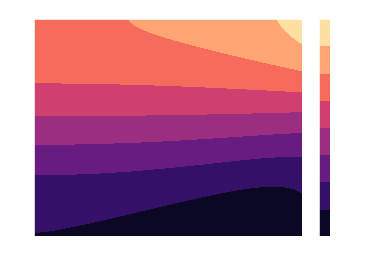

In [37]:

plt.figure()
plt.contourf(f_Model/1e3,phi_Model,
             PSDTodB(LaserFreq_Model_PSD+LaserRIN_Model_PSD)
#              ,np.arange(-1.5,15,2)
            )
plt.colorbar()
plt.title('Contribution of Laser Noise')

In [38]:
print('''The contribution of laser frequency and amplitude noise from the MATLAB model contribute less than -50 dB.
In real life, RIN was at roughly -20 dB, but is taken into account in the shot noise.
In real life, the laser frequency noise was canceled well below interesting levels for measurement by chosing fiber lengths
acrefully (but it could still be showing up as a small part of the differntial phase noise) .''')

The contribution of laser frequency and amplitude noise from the MATLAB model contribute less than -50 dB.
In real life, RIN was at roughly -20 dB, but is taken into account in the shot noise.
In real life, the laser frequency noise was canceled well below interesting levels for measurement by chosing fiber lengths
acrefully (but it could still be showing up as a small part of the differntial phase noise) .


### Add BS1 to Model

In [39]:
## Apply BS1 loss that is missing in the model

Total_Model_afterBS1_PSD = applyloss(Total_Model_PSD,BS1_Loss);
Quantum_Model_afterBS1_PSD = (applyloss(Quantum_Model_PSD,BS1_Loss));
Thermal_Model_afterBS1_PSD = (Thermal_Model_PSD*(1-BS1_Loss));

Total_Model_Model_TN_afterBS1_PSD = applyloss(Total_Model_Model_TN_PSD,BS1_Loss);


## Get common frequency and quadratures for measurement and model

## Frequency

In [40]:
## Max frequency of squeezing measurement is higher than the max frequency of thermal noise measurement

# f_meas is the frequency array of squeezing measurement
# f_Model is the frequency array of the model, which in turn is based on the frequency array of the thermal noise measurement

print(min(f_meas))
print(min(f_Model))
print(f_meas[8])

print(max(f_meas))
print(max(f_Model))
print(f_meas[781])

# So the useful frequency array from f_meas is the one between indices 8 and 781.


0.0
1024
1024.0
102400.0
99968
99968.0


### Squeezing measurements have a bigger frequency range than the thermal noise measurement, so select the common range

In [41]:
f_meas_Inbounds_f = f_meas[8:781].squeeze()
spec_Inbounds_f_ASD = spec_sorted[:,8:781]
# Feedback_Noise_PSD_Max = Feedback_Noise_PSD_Max[8:781]
Diff_Phase_Noise_inbounds_f_PSD = Diff_Phase_Noise_meas_PSD[:,8:781]
Feedback_Noise_meas_inbounds_f_PSD = Feedback_Noise_meas_PSD[:,8:781]
# Convert to PSD
#spec_Inbounds_f=spec_Inbounds_f**2

# Convert to dB
spec_Inbounds_f=20*np.log10(spec_Inbounds_f_ASD)


In [42]:
f_kHz = f_meas_Inbounds_f*1e-3

### Interpolate the model to match measurement frequency and angles

In [43]:
# Now we have f which is from the thermal noise measurement and hence the model
# that has 3554 points, and f_meas from the squeezing measurements with 801
# points.
# phi_sorted is angles from measurements

# Total_model is the noise of interest from the squeezing model
# spec_sorted is from measurement

# so we need to interpolate f and find the points that match f_meas

Total_Model_afterBS1_Interp_f_PSD = interp1d(f_Model,Total_Model_afterBS1_PSD)(f_meas_Inbounds_f);
Quantum_Model_afterBS1_Interp_f_PSD = interp1d(f_Model,Quantum_Model_afterBS1_PSD)(f_meas_Inbounds_f);
Thermal_Model_afterBS1_Interp_f_PSD = interp1d(f_Model,Thermal_Model_afterBS1_PSD)(f_meas_Inbounds_f);


## Also interpolate phi
Total_Model_afterBS1_Interp_f_interp_phi_PSD = interp1d(phi_Model,Total_Model_afterBS1_Interp_f_PSD.transpose())(phi_sorted);
Total_Model_afterBS1_Interp_f_interp_phi_PSD = Total_Model_afterBS1_Interp_f_interp_phi_PSD.transpose()

Quantum_Model_afterBS1_Interp_f_interp_phi_PSD = interp1d(phi_Model,Quantum_Model_afterBS1_Interp_f_PSD.transpose())(phi_sorted);
Quantum_Model_afterBS1_Interp_f_interp_phi_PSD = Quantum_Model_afterBS1_Interp_f_interp_phi_PSD.transpose()

Thermal_Model_afterBS1_Interp_f_interp_phi_PSD = interp1d(phi_Model,Thermal_Model_afterBS1_Interp_f_PSD.transpose())(phi_sorted);
Thermal_Model_afterBS1_Interp_f_interp_phi_PSD = Thermal_Model_afterBS1_Interp_f_interp_phi_PSD.transpose()


# Excess loss

## Estimate excess loss

In [44]:
ExcessLossOptions = (np.arange(0,.6,.001))
ind_low_cut_off = (np.abs(f_kHz-f_interest_low_kHz)).argmin()
ind_high_cut_off = (np.abs(f_kHz-f_interest_high_kHz)).argmin()
i = 0
chi_2_fullrange = []
chi_2_cutoff = []

for L_excess in ExcessLossOptions:
    Total_Model_after_excess_loss_option_PSD = applyloss(Total_Model_afterBS1_Interp_f_interp_phi_PSD,L_excess)+ \
        Feedback_Noise_meas_inbounds_f_PSD + Diff_Phase_Noise_inbounds_f_PSD
#    Total_Model_final_after_excess_loss_dB = PSDTodB(Total_Model_final_after_excess_loss_PSD)
    
    Meas_PSD = dBToPSD(spec_Inbounds_f)
    error = (Meas_PSD-Total_Model_after_excess_loss_option_PSD)/Meas_PSD
    chi_2_fullrange.append(np.mean(error**2))
    chi_2_cutoff.append(np.mean(error[:,ind_low_cut_off:ind_high_cut_off]**2))
    i += 1    

chi_2_fullrange = np.array(chi_2_fullrange)
chi_2_cutoff = np.array(chi_2_cutoff)

In [45]:
chi_2_min_cutoff = np.min(chi_2_cutoff)
chi_2_min_fullrange = np.min(chi_2_fullrange)
ind_min_chi_2_cutoff = np.abs(chi_2_cutoff - chi_2_min_cutoff).argmin()
ind_min_chi_2_fullrange = np.abs(chi_2_fullrange - chi_2_min_fullrange).argmin()

In [46]:
FitLoss_cutoff = ExcessLossOptions[ind_min_chi_2_cutoff]
FitLoss_fullrange = ExcessLossOptions[ind_min_chi_2_fullrange]

# TotalLoss_cutoff = 1-((1-BS1_Loss)*(1-FitLoss_cutoff))
# TotalLoss_fullrange = 1 - ((1-BS1_Loss)*(1-FitLoss_fullrange))


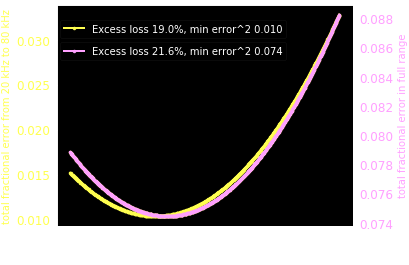

In [47]:
#fig, ax1 = plt.subplots(figsize = [10,6])
fig, ax1 = plt.subplots()

# color1 = 'tab:red'
ax1.set_xlabel('Excess Loss (%)')
h1=ax1.plot(ExcessLossOptions*100,chi_2_cutoff, marker='.',\
        label = 'Excess loss {:.1f}%, min error^2 {:.3f}'.format(FitLoss_cutoff*100, chi_2_min_cutoff))
color1 = h1[0].get_color()
ax1.set_ylabel('total fractional error from {} kHz to {} kHz'.\
               format(f_interest_low_kHz,f_interest_high_kHz), color=color1\
              ,fontsize=10)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.legend(loc = [.01,.85],fontsize=10)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# color2 = 'tab:blue'
ax2.plot(ExcessLossOptions*100, chi_2_fullrange,marker='.',linewidth=0)
h2=ax2.plot(ExcessLossOptions*100, chi_2_fullrange,marker='.',\
         label = 'Excess loss {:.1f}%, min error^2 {:.3f}'.format((FitLoss_fullrange*100),chi_2_min_fullrange))
color2=h2[0].get_color()
ax2.set_ylabel('total fractional error in full range', color=color2\
              ,fontsize=10)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color2)
ax2.legend(loc=[.01,.75],fontsize=10)
fig.tight_layout()  # otherwise the right y-label is slightly clipped

if save_figures:
    plt.savefig(SaveDirFig+'Lossfit_full.pdf', bbox_inches='tight',dpi=300)
    plt.savefig(SaveDirFig+'Lossfit_full.png', bbox_inches='tight',dpi=300)

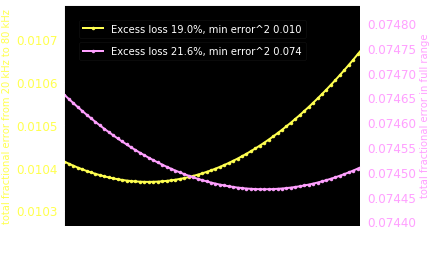

In [48]:
# fig, ax1 = plt.subplots(figsize = [10,6])
fig, ax1 = plt.subplots()

# color1 = 'tab:red'
ax1.set_xlabel('Excess Loss (%)')
h1=ax1.plot(ExcessLossOptions*100,chi_2_cutoff, color=color1,marker='.',\
         label = 'Excess loss {:.1f}%, min error^2 {:.3f}'.format(FitLoss_cutoff*100, chi_2_min_cutoff))
color1=h1[0].get_color()
ax1.set_ylabel('total fractional error from {} kHz to {} kHz'.\
               format(f_interest_low_kHz,f_interest_high_kHz), color=color1,fontsize = 10)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.legend(loc = [.05,.85],fontsize=10)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# color2 = 'tab:blue'
h2=ax2.plot(ExcessLossOptions*100, chi_2_fullrange, color=color2,marker='.',\
          label = 'Excess loss {:.1f}%, min error^2 {:.3f}'.format((FitLoss_fullrange*100),chi_2_min_fullrange))
color2=h2[0].get_color()
ax2.set_ylabel('total fractional error in full range', color=color2\
              ,fontsize = 10)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color2)
ax2.legend(loc=[.05,.75],fontsize=10)
fig.tight_layout()  # otherwise the right y-label is slightly clipped

ax1.set_xlim([np.min([FitLoss_cutoff*90,FitLoss_fullrange*90]),np.max([FitLoss_cutoff*110,FitLoss_fullrange*110])])
ax1.set_ylim([chi_2_min_cutoff*.99,chi_2_min_cutoff*1.04])
ax2.set_ylim([chi_2_min_fullrange*0.999,chi_2_min_fullrange*1.005])


if save_figures:
    plt.savefig(SaveDirFig+'Lossfit_zoom.pdf', bbox_inches='tight',dpi=300)
    plt.savefig(SaveDirFig+'Lossfit_zoom.png', bbox_inches='tight',dpi=300)

## Add this loss to the model

In [49]:
excess_loss_from_fit = FitLoss_fullrange

In [50]:
Total_Model_after_excess_loss_afterBS1_Interp_f_interp_phi_PSD = \
        applyloss(Total_Model_afterBS1_Interp_f_interp_phi_PSD,excess_loss_from_fit)+ \
        Feedback_Noise_meas_inbounds_f_PSD + Diff_Phase_Noise_inbounds_f_PSD


Quantum_Model_after_excess_loss_afterBS1_Interp_f_interp_phi_PSD = \
        applyloss(Quantum_Model_afterBS1_Interp_f_interp_phi_PSD,excess_loss_from_fit)

Thermal_Model_after_excess_loss_afterBS1_Interp_f_interp_phi_PSD = \
        Thermal_Model_afterBS1_Interp_f_interp_phi_PSD*(1-excess_loss_from_fit)


# Correlation calibrated squeezing measurement

## Load correlation measurement

In [51]:
cross_amp = np.loadtxt('../Measurements/correlation/corr2_Cross_Spectrum_amp.dat')
cross_phase = np.loadtxt('../Measurements/correlation/corr2_Cross_Spectrum_phase.dat')
pwr_spec1 = np.loadtxt('../Measurements/correlation/corr2_PwrSpec1.dat')
pwr_spec2 = np.loadtxt('../Measurements/correlation/corr2_PwrSpec2.dat')

Sab = cross_amp[:,1] * np.cos(cross_phase[:,1]*np.pi/180) # take the real part with the proper sign

# Looking at the meta-data files for cross_amp, pwrspec1, and pwrspec2, one finds that cross_amp and pwrspec2 were measured in rms
# while pwrspec1 was recorded in Vpk-pk. so we must correct for that by a factor of sqrt(2)**2 in psd for pwrspec1.

Sa = pwr_spec1[:,1]/2 
Sb = pwr_spec2[:,1]

C = Sab/np.sqrt(Sa*Sb)
R = (1+C)/(1-C)
f_correlation_kHz = pwr_spec1[:,0]*1e-3
R_dB = PSDTodB(R)

## Calculate errorbar in quadrature inference for correlation measurement

Since the BS_2 reflectivity drops out of the calculation of the quadrature, it means that to calculate the quadrature for correlation measurement, all one needs is the final readings that were taken on the measurement photodiode.
The BS3 reflectivity will similarly drop out of the calculation, the only important thing is to use the voltages after all beam splitters.

In [52]:

# To set up the correlation-calibrated measurement to be close to squeezing quadrature, 
# each voltages on one of the photodiodes after the 50/50 beamsplitter were set to be half of,
# the corresponding voltage for the shotnoise calibrated measurement

cav_power_array = CavPower/2*np.arange(1-cav_power_error,1+cav_power_error,cav_power_error/10)
LO_power_array = LO_power_sqz_quad/2*np.arange(1-LO_power_error,1+LO_power_error,LO_power_error/10)
Total_power_array = TotalPower/2*np.arange(1-Total_power_error,1+Total_power_error,Total_power_error/10)
w = len(LO_power_array)
h = len(cav_power_array)
d = len(Total_power_array)

phi_matrix_3 = [[[0 for x in range(w)] for y in range(h)] for z in range(d)]

for k in np.arange(len(Total_power_array)):
    for i in np.arange(len(cav_power_array)):
        for j in np.arange(len(LO_power_array)):
            phi_matrix_3[k][i][j]=phi(cav_power_array[i],LO_power_array[j],Total_power_array[k],Visibility,DV)[0]


# plt.contourf(LO_power,cav_power,Matrix[int((0))])
# plt.ylabel('P_Cav')
# # plt.yticks((1.19,1.24,1.29,1.34,1.39))
# plt.xlabel('P_LO')
# plt.colorbar()
# plt.show()

In [53]:
print('Quadrature range for correlation calibrated measurement is ({:0.1f} ,{:0.1f}) degrees'
      .format(np.array(phi_matrix_3).min(),np.array(phi_matrix_3).max()))

Quadrature range for correlation calibrated measurement is (9.7 ,12.9) degrees


## $\chi^2$ fit to deduce quadrature of correlation calibrated measurement from interpolated shot-noise calibrated measurement

In [54]:
correlation_measurement_phi_range = np.arange(10,15,.01) # Say the correlation measurement was performed at some angle between 10 and 15 degrees


# Now interpolate the homdodyne measurement over all frequencies and quadratures:
SN_calibrated_measurement_interpolated_PSD = interp2d(f_kHz,phi_sorted,spec_Inbounds_f_ASD**2);

# Define two chi_squared measures, one over the entire frequency range, and second over the frequencies of interest

ind_low_cut_off = (np.abs(f_correlation_kHz-f_interest_low_kHz)).argmin()
ind_high_cut_off = (np.abs(f_correlation_kHz-f_interest_high_kHz)).argmin()

chi_2_correlation_quadrature_fullrange = []
chi_2_correlation_quadrature_cutoff = []

for phi_ii in correlation_measurement_phi_range:
    correlation_measurement_PSD = R
    SN_calibrated_measurement_at_phi_ii_PSD = SN_calibrated_measurement_interpolated_PSD(f_correlation_kHz,phi_ii)
    error = (correlation_measurement_PSD-SN_calibrated_measurement_at_phi_ii_PSD)/SN_calibrated_measurement_at_phi_ii_PSD
    chi_2_correlation_quadrature_fullrange.append(np.mean(error**2))
    chi_2_correlation_quadrature_cutoff.append(np.mean(error[ind_low_cut_off:ind_high_cut_off]**2))
    
chi_2_correlation_quadrature_fullrange = np.array(chi_2_correlation_quadrature_fullrange)
chi_2_correlation_quadrature_cutoff = np.array(chi_2_correlation_quadrature_cutoff)

chi_2_correlation_quadrature_min_cutoff = np.min(chi_2_correlation_quadrature_cutoff)
chi_2_correlation_quadrature_min_fullrange = np.min(chi_2_correlation_quadrature_fullrange)
ind_min_chi_2_cutoff = np.abs(chi_2_correlation_quadrature_cutoff - chi_2_correlation_quadrature_min_cutoff).argmin()
ind_min_chi_2_fullrange = np.abs(chi_2_correlation_quadrature_fullrange - chi_2_correlation_quadrature_min_fullrange).argmin()

FitQuadrature_cutoff = correlation_measurement_phi_range[ind_min_chi_2_cutoff]
FitQuadrature_fullrange = correlation_measurement_phi_range[ind_min_chi_2_fullrange]

In [55]:
SN_calibrated_measurement_at_fit_quadrature_cutoff_dB=PSDTodB(SN_calibrated_measurement_interpolated_PSD(f_correlation_kHz,FitQuadrature_cutoff))
SN_calibrated_measurement_at_fit_quadrature_fullrange_dB=PSDTodB(SN_calibrated_measurement_interpolated_PSD(f_correlation_kHz,FitQuadrature_fullrange))

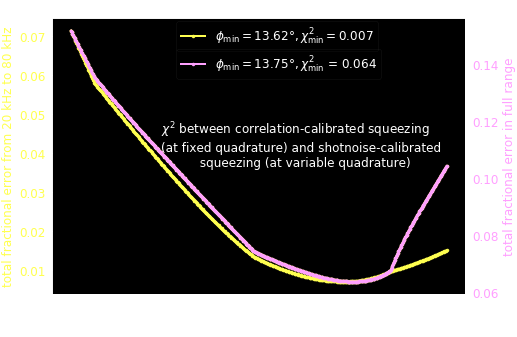

In [56]:
fig, ax1 = plt.subplots(figsize = [7.5,5])
# fig, ax1 = plt.subplots()


h1=ax1.plot(correlation_measurement_phi_range,chi_2_correlation_quadrature_cutoff, marker='.',\
        label = '$\phi_\mathrm{{min}} = {:.2f}\degree, \chi^2_\mathrm{{min}} = {:.3f}$'.format(FitQuadrature_cutoff, chi_2_correlation_quadrature_min_cutoff))
color1=h1[0].get_color()
ax1.set_xlabel('$\phi_\mathrm{{SN}}$ (degrees)')
ax1.set_ylabel('total fractional error from {} kHz to {} kHz'.format(f_interest_low_kHz,f_interest_high_kHz), color=color1)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.legend(loc = [0.3,.88])
plt.title('Error between squeezing calibration techniques')
ax1.text(11.2,.037,'$\chi^2$ between correlation-calibrated squeezing \
         \n(at fixed quadrature) and shotnoise-calibrated\n \
         squeezing (at variable quadrature) ',fontsize=12)
# plt.grid()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

# color2 = 'tab:blue'
ax2.plot(correlation_measurement_phi_range, chi_2_correlation_quadrature_fullrange, marker='.')
h2=ax2.plot(correlation_measurement_phi_range, chi_2_correlation_quadrature_fullrange, marker='.',\
         label = '$\phi_\mathrm{{min}} = {:.2f}\degree, \chi^2_\mathrm{{min}}$ = {:.3f}'.format((FitQuadrature_fullrange),chi_2_correlation_quadrature_min_fullrange))
color2=h2[0].get_color()
ax2.set_ylabel('total fractional error in full range', color=color2)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color2)
ax2.legend(loc=[0.3,.78])
# ax2.legend(loc='best')
# ax2.hlines(0.08,np.array(phi_matrix_3).min(),np.array(phi_matrix_3).max())
fig.tight_layout()

if save_figures:
    plt.savefig(SaveDirFig+'correlation_measurement_quadrature_fit.png',bbox_inches='tight',dpi=300)
else:
    plt.show()

if is_script:
    plt.close('all')

### Interpolate error in quadrature in SN-calibrated measurement at the quadrature obtained by $\chi^2$

In [57]:
FitQuadrature_cutoff_max=interp1d(phi_pos,phi_pos_max)(FitQuadrature_cutoff)
FitQuadrature_cutoff_min=interp1d(phi_pos,phi_pos_min)(FitQuadrature_cutoff)

In [58]:
print('Range of shotnoise calibrated quadratures centered around {:0.1f} degrees is ({:0.1f},{:0.1f}) degrees which does overlap with the range of of quadratures allowed for correlation calibrated measurement ({:0.1f},{:0.1f}) degrees'
      .format(FitQuadrature_cutoff,FitQuadrature_cutoff_min,FitQuadrature_cutoff_max,np.array(phi_matrix_3).min(),np.array(phi_matrix_3).max()))

Range of shotnoise calibrated quadratures centered around 13.6 degrees is (11.8,14.7) degrees which does overlap with the range of of quadratures allowed for correlation calibrated measurement (9.7,12.9) degrees


# Plotting

## Clean up variable names

In [59]:
## Final noise

Total_Model_Model_TN_final_no_technical_noise_PSD = Total_Model_Model_TN_afterBS1_PSD

Total_Model_final_no_technical_noise_PSD = Total_Model_afterBS1_PSD
Total_Model_final_PSD = Total_Model_after_excess_loss_afterBS1_Interp_f_interp_phi_PSD
Quantum_Model_final_PSD = Quantum_Model_after_excess_loss_afterBS1_Interp_f_interp_phi_PSD
Thermal_Model_final_PSD = Thermal_Model_after_excess_loss_afterBS1_Interp_f_interp_phi_PSD

Feedback_Noise_final_PSD = Feedback_Noise_meas_inbounds_f_PSD
Diff_Phase_Noise_final_PSD = Diff_Phase_Noise_inbounds_f_PSD

## Convert Model to dBs

In [60]:
#dBs

Total_Model_Model_TN_final_no_technical_noise_dB = PSDTodB(Total_Model_Model_TN_final_no_technical_noise_PSD)
Total_Model_final_no_technical_noise_dB = PSDTodB(Total_Model_final_no_technical_noise_PSD)
Total_Model_final_dB = PSDTodB(Total_Model_final_PSD);
Quantum_Model_final_dB = PSDTodB(Quantum_Model_final_PSD);
Thermal_Model_final_dB = PSDTodB(Thermal_Model_final_PSD);
Feedback_Noise_final_dB = PSDTodB(Feedback_Noise_final_PSD);
Diff_Phase_Noise_final_dB = PSDTodB(Diff_Phase_Noise_final_PSD);


Total_Model_final_dB = PSDTodB(Quantum_Model_final_PSD+Thermal_Model_final_PSD+
                               Feedback_Noise_final_PSD+Diff_Phase_Noise_final_PSD)


## System characterization

### Homodyne Loop TF

### (Fig 10)

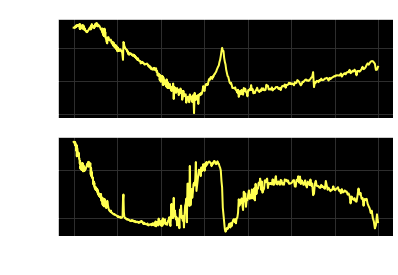

In [61]:
# plt.figure(figsize=(9,9*8/12))
plt.figure()
plt.subplot(2,1,1)
plt.plot(HomodyneLoop_f*1e-3,HomodyneLoop_Amp,linewidth=2)
plt.ylabel('Magnitude, (dB)')
#plt.xlim([90e3,210e3])
plt.grid(True)
plt.title('Open loop gain for homodyne loop')

plt.subplot(2,1,2)
plt.plot(HomodyneLoop_f*1e-3,HomodyneLoop_Phase,linewidth=2)
#plt.xlim([90e3,210e3])
plt.ylabel('Phase, (deg)')
plt.grid(True)
plt.xlabel('Frequency (kHz)')

if save_figures:
    plt.savefig(SaveDirFig+'10.png', bbox_inches='tight',dpi=300)
    plt.savefig(SaveDirFig+'10.pdf', bbox_inches='tight',dpi=300)

### Cavity Locking Bode

### (not in the paper)

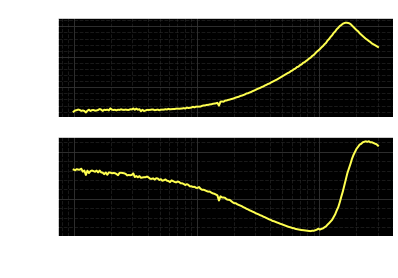

In [62]:
# plt.figure(figsize=(9,9*8/12))
plt.figure()
plt.subplot(2,1,1)
plt.plot(CavityOLG_f,CavityOLG_Amp,linewidth=2)
plt.xscale('log')
plt.ylabel('Magnitude, (dB)')
#plt.xlim([90e3,210e3])
plt.grid(True)
plt.minorticks_on()
plt.grid(which='minor',linestyle='--',alpha=0.5)
plt.title('Open loop gain for cavity locking loop')

plt.subplot(2,1,2)
plt.plot(CavityOLG_f,CavityOLG_Phase,linewidth=2)
plt.xscale('log')
#plt.xlim([90e3,210e3])
plt.ylabel('Phase, (deg)')
plt.grid(True)
plt.minorticks_on()
plt.grid(which='minor',linestyle='--',alpha=0.5)
plt.xlabel('Frequency (Hz)')

if save_figures:
    plt.savefig(SaveDirFig+'CavityLoop.png', bbox_inches='tight',dpi=300)
    plt.savefig(SaveDirFig+'CavityLoop.pdf', bbox_inches='tight',dpi=300)

### Compare OS Plot

### (not in the paper)

This plot should be made for the 'model_TN' because the 'meas_TN' frequencies dont go higher than 100kHz

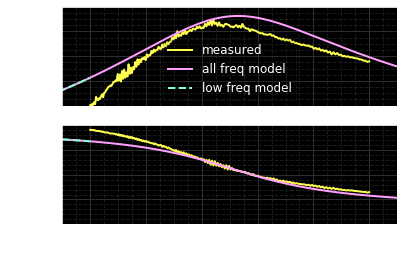

In [63]:
# plt.figure(figsize=(10,7))
plt.figure()
plt.subplot(2,1,1)
plt.plot(OS_meas_f*1e-3,OS_meas_Amp,label='measured',linewidth=2)
plt.plot(f_Model_Model_TN*1e-3,20*np.log10(abs(OSTF_Model_TN))-40,label='all freq model',linewidth=2)
plt.plot(f_Model*1e-3,20*np.log10(abs(OSTF))-40,label='low freq model',linewidth=2,linestyle='--')
plt.ylabel('Magnitude, (dB)')
plt.xlim([90,210])
plt.ylim([-45,-35])
plt.grid(True)
plt.minorticks_on()
plt.grid(which='minor',linestyle='--',alpha=0.5)

plt.legend()

plt.subplot(2,1,2)
plt.plot(OS_meas_f*1e-3,135-OS_meas_Phase,linewidth=2)
plt.plot(f_Model_Model_TN*1e-3,np.rad2deg(np.angle(OSTF_Model_TN)),linewidth=2)
plt.plot(f_Model*1e-3,np.rad2deg(np.angle(OSTF)),linewidth=2,linestyle='--')
plt.xlim([90,210])
plt.ylabel('Phase, (deg)')
plt.grid(True)
plt.ylim([0,200])
plt.minorticks_on()
plt.grid(which='minor',linestyle='--',alpha=0.5)
plt.xlabel('Frequency, (kHz)')

if save_figures:
    plt.savefig(SaveDirFig+'OS_comapre.png', bbox_inches='tight',dpi=300)
    plt.savefig(SaveDirFig+'OS_compare.pdf', bbox_inches='tight',dpi=300)

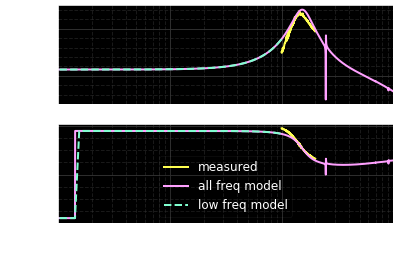

In [64]:
# plt.figure(figsize=(10,7))
plt.figure()
plt.subplot(2,1,1)
plt.semilogx(OS_meas_f,OS_meas_Amp,label='measured',linewidth=2)
plt.semilogx(f_Model_Model_TN,20*np.log10(abs(OSTF_Model_TN))-40,label='all freq model',linewidth=2)
plt.semilogx(f_Model,20*np.log10(abs(OSTF))-40,label='low freq model',linewidth=2,linestyle='--')
plt.ylabel('Magnitude, (dB)')
plt.xlim([1e3,1e6])
# plt.ylim([-45,-35])
plt.grid(True)
plt.minorticks_on()
plt.grid(which='minor',linestyle='--',alpha=0.5)


plt.subplot(2,1,2)
plt.semilogx(OS_meas_f,135-OS_meas_Phase,linewidth=2,label='measured')
plt.semilogx(f_Model_Model_TN,np.rad2deg(np.angle(OSTF_Model_TN)),linewidth=2,label='all freq model')
plt.semilogx(f_Model,np.rad2deg(np.angle(OSTF)),linewidth=2,label='low freq model',linestyle='--')
plt.xlim([1e3,1e6])

plt.ylabel('Phase, (deg)')
plt.grid(True)
# plt.ylim([0,200])
plt.minorticks_on()
plt.grid(which='minor',linestyle='--',alpha=0.5)
plt.xlabel('Frequency, (Hz)')
plt.legend(loc='best')

if save_figures:
    plt.savefig(SaveDirFig+'OS_comapre_full_freq.png', bbox_inches='tight',dpi=300)
    plt.savefig(SaveDirFig+'OS_compare_full_freq.pdf', bbox_inches='tight',dpi=300)

### Shot noise plot

### (Fig 8)

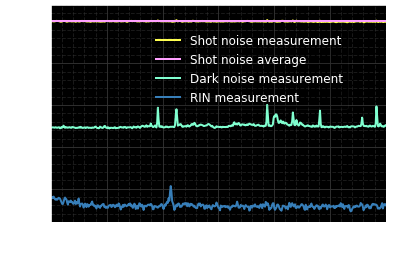

In [65]:
# plt.figure(figsize=(9,9*8/12))
plt.figure()
plt.plot(SNdata[:,0]*1e-3,SNdB,label = 'Shot noise measurement',linewidth = 2)
plt.plot(SNdata[:,0]*1e-3,0*SNdata[:,1]/SNdata[:,1],label = 'Shot noise average',linewidth = 2)
plt.plot(DNdata[:,0]*1e-3,DNdB,label = 'Dark noise measurement',linewidth = 2)
plt.plot(RINdata[:,0]*1e-3,RINdB,label = 'RIN measurement',linewidth = 2)
plt.xlim([f_interest_low_kHz,f_interest_high_kHz])
plt.ylim([-24,2])
plt.ylabel('Total Noise w.r.t shot noise (dB)')
plt.xlabel('Frequency (kHz)')
plt.grid(True)
plt.minorticks_on()
plt.grid(which='minor',linestyle='--',alpha=0.5)
plt.legend(loc=[.3,0.52])

if save_figures:
    plt.savefig(SaveDirFig+'8.png',bbox_inches='tight',dpi=300)
    plt.savefig(SaveDirFig+'8.pdf',bbox_inches='tight',dpi=300)
else:
    plt.show()
if is_script:
    plt.close('all')

### Squeezing expected without technical noises.

### (Fig 5)

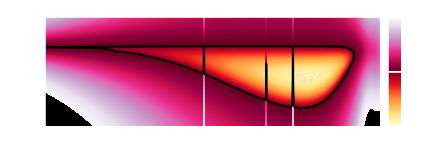

In [66]:
AS_range_contour = np.arange(0,15,.1)
AS_range_ticks   = np.arange(0,15,1)
AS_tick_labels   =[]
for i in AS_range_ticks:
    if np.mod(i,5)<1:
        AS_tick_labels.append(i)
    else:
        AS_tick_labels.append('')
        
S_range_contour = np.arange(-1.5,0,0.01)
S_range_ticks   = np.around(np.arange(-1.5,0,0.1),decimals = 1)
S_tick_labels = []
for i in S_range_ticks:
    if np.mod(-10*i,5)<1:
        S_tick_labels.append('%.1f'%(i))
    else:
        S_tick_labels.append('')

fig = plt.figure(figsize=(6,2))
# fig = plt.figure()

Model_AS_Plot=plt.contourf(f_Model_Model_TN,phi_Model_Model_TN,(Total_Model_Model_TN_final_no_technical_noise_dB),\
                           AS_range_contour,cmap=plt.cm.PuRd_r)
Model_S_Plot=plt.contourf(f_Model_Model_TN,phi_Model_Model_TN,(Total_Model_Model_TN_final_no_technical_noise_dB),\
                          S_range_contour,cmap = plt.cm.YlOrRd)
Model_0_Plot=plt.contour(f_Model_Model_TN,phi_Model_Model_TN,(Total_Model_Model_TN_final_no_technical_noise_dB),[0],colors='k')
plt.title('Total expected noise wrt shot noise, (dB)', {'size':12})


plt.ylabel('$\phi$ (Degrees)',{'size':12})
plt.ylim([0,25])
plt.yticks(fontsize = 12)

plt.xlabel('Frequency (Hz)',{'size':12})
plt.xscale('log')
plt.xlim([1e2,2e5])

#plt.xscale('log')
#plt.xlim([1e2,2e5])
#plt.xlabel('Frequency (Hz)',{'size':12})

plt.xticks(fontsize = 12)

for c in Model_AS_Plot.collections:
    c.set_edgecolor("face") # to remove little white lines at the boundaries of contours
    
for c in Model_S_Plot.collections:
    c.set_edgecolor("face") # to remove little white lines at the boundaries of contours

cbaxes_AS = fig.add_axes([.92, 0.503, 0.03, 0.37]) 
cb_AS = plt.colorbar(Model_AS_Plot, cax = cbaxes_AS,ticks = AS_range_ticks,format='%.0f')  
cb_AS.set_ticklabels(AS_tick_labels)
cb_AS.ax.tick_params(labelsize=12)

cbaxes_S = fig.add_axes([.92, 0.13, 0.03, 0.37]) 
cb_S = plt.colorbar(Model_S_Plot, cax = cbaxes_S,ticks = S_range_ticks,format='%.0f')  
cb_S.set_ticklabels(S_tick_labels)
cb_S.ax.tick_params(labelsize = 12)

# from matplotlib.ticker import LogFormatter 
# formatter = LogFormatter(10, labelOnlyBase=False) 
# Take spec, phi and freq 0 from previous cells and plot contour plot
# White contour is 0dB line
# # 
# cmap = plt.cm.bone or pink
# 


if save_figures:
    plt.savefig(SaveDirFig+'5.png', bbox_inches='tight',dpi=300)
#     plt.savefig(SaveDirFig+'5.pdf', bbox_inches='tight',dpi=300)

## Full Noise Budgets

### Full noise budget in squeezing frequency bin
### (Fig 6)
This cell can in principle be used to generate the full noise budget in any frequency bin. Change the ylim to what makes most sense.

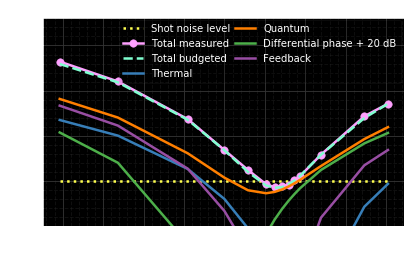

In [67]:
f_low_kHz  = 45
f_high_kHz = 46
idx_low    = (np.abs(f_kHz-f_low_kHz)).argmin()
idx_high   = (np.abs(f_kHz-f_high_kHz)).argmin()+1 # that's because idex_low:idx_high actually only gives elements from idx_low to idx_high-1

average_spec =  np.mean(spec_Inbounds_f[:,idx_low:idx_high],axis=1)
average_total = np.mean(Total_Model_final_dB[:,idx_low:idx_high],axis=1)
average_thermal = np.mean(Thermal_Model_final_dB[:,idx_low:idx_high],axis=1)
average_quantum = np.mean(Quantum_Model_final_dB[:,idx_low:idx_high],axis=1)
average_diff_phase = np.mean(Diff_Phase_Noise_final_dB[:,idx_low:idx_high],axis=1)
average_feedback = np.mean(Feedback_Noise_final_dB[:,idx_low:idx_high],axis=1)



fig  = plt.figure(figsize = (11/1.7,6.5/1.7))
plt.plot(phi_sorted,np.zeros(len(phi_sorted)),\
         linestyle=':',linewidth=2.5,label='Shot noise level');
plt.plot(phi_sorted,average_spec,\
        linestyle='-',linewidth=2.5,markersize=15,marker='.',label='Total measured')
plt.plot(phi_sorted,average_total,linestyle = '--',linewidth = 2.5,label='Total budgeted')
plt.plot(phi_sorted,average_thermal,label='Thermal',linewidth=2.5)
plt.plot(phi_sorted,average_quantum,label='Quantum',linewidth=2.5)
plt.plot(phi_sorted,average_diff_phase+20,label='Differential phase + 20 dB',linewidth=2.5)
plt.plot(phi_sorted,average_feedback,label='Feedback',linewidth=2.5)

plt.title('Average in %.1f kHz - %.1f kHz bin' %(f_meas[idx_low]/1000, f_meas[idx_high]/1000));
plt.ylim([-5, 18])
#plt.xlim([-45, 60])
# legend('Unity','Measured noise','ThermalNoise','QuantumNoise','TotalModel','CM AMP'); 
plt.grid(True)
plt.minorticks_on()
plt.grid(which='minor',linestyle='--',alpha = 0.3)
#plt.legend(('Shot noise level','Total measured noise','Total expected noise','Thermal noise','Quantum noise',\
#            'Differential phase noise','Feedback noise'),loc=[1,0]); 

plt.legend(loc=[.21,0.69],ncol = 2,fontsize = 10,columnspacing = .5); 
plt.xlabel('$\phi$ (degrees)')
plt.ylabel('Noise relative to shot noise (dB)')

if save_figures:
    if idx_low==344:
        plt.savefig(SaveDirFig+'6.pdf' ,bbox_inches = 'tight',dpi=300)
        plt.savefig(SaveDirFig+'6.png' ,bbox_inches = 'tight',dpi=300)
    else:
        plt.savefig(SaveDirFig+'Full_Noise_budget_McD_avg_%0.1fkHz_updated.pdf' %(f_kHz[idx_low]),bbox_inches = 'tight',dpi=300)
        plt.savefig(SaveDirFig+'Full_Noise_budget_McD_avg_%0.1fkHz_updated.png' %(f_kHz[idx_low]),bbox_inches = 'tight',dpi=300)

### Mc Donalds plot at a single frequency instead of average in a bin
### (not in paper)

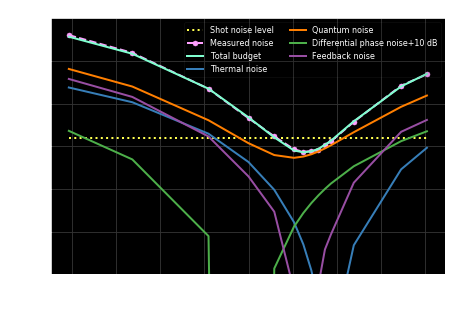

In [68]:
# Also plot noise budget at chosen frequency
freq_NB_kHz = 45;
ind_freq = (np.abs(f_kHz-freq_NB_kHz)).argmin() # Grab Indices for plotting at a certain frequency freq_NB

fig=plt.figure(figsize=(12/1.7,8/1.7))
# fig=plt.figure()
plt.plot(phi_sorted,np.ones(len(phi_sorted)),label='Shot noise level',\
         linestyle=':',linewidth=2);
plt.plot(phi_sorted,spec_Inbounds_f[:,ind_freq],label='Measured noise',\
        linestyle='--',linewidth=2,markersize=10,marker='.')
plt.plot(phi_sorted,Total_Model_final_dB[:,ind_freq],label='Total budget')
plt.plot(phi_sorted,Thermal_Model_final_dB[:,ind_freq],label='Thermal noise')
plt.plot(phi_sorted,Quantum_Model_final_dB[:,ind_freq],label='Quantum noise')
plt.plot(phi_sorted,Diff_Phase_Noise_final_dB[:,ind_freq]+10,label='Differential phase noise+10 dB')
plt.plot(phi_sorted,Feedback_Noise_final_dB[:,ind_freq],label='Feedback noise')

plt.title('Frequency = %0.1f  kHz' %(f_meas_Inbounds_f[ind_freq]/1e3));
plt.ylim([-15, 15])
#plt.xlim([5,18])
#legend('Unity','Measured noise','ThermalNoise','QuantumNoise','TotalModel','CM AMP'); 
plt.grid(True)
plt.legend(prop={'size': 8},ncol=2); 
plt.xlabel('$\phi$ (degrees)')
plt.ylabel('Noise relative to shot noise (dB)')

if save_figures:
    plt.savefig(SaveDirFig+'Full_Noise_budget_McD_%0.1fkHz.pdf' %(f_meas_Inbounds_f[ind_freq]/1e3),bbox_inches = 'tight',dpi=300)
    plt.savefig(SaveDirFig+'Full_Noise_budget_McD_%0.1fkHz.png' %(f_meas_Inbounds_f[ind_freq]/1e3),bbox_inches = 'tight',dpi=300)




### Full noise budget at squeezing quadrature
### (Fig 7)
This cell can in principle be used to generate the full noise budget at any quadrature. Change the ylim to what makes most sense.

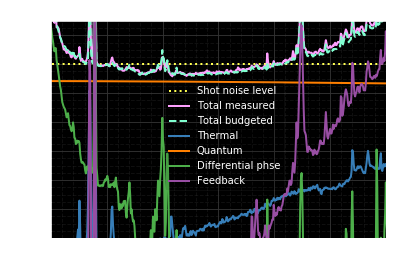

In [69]:
# Also plot noise budget at chosen quadrature
phi_NB = 12 ;
ind_phi_meas = (np.abs(phi_sorted-phi_NB)).argmin() # Grab Indices for plotting measurement at the quadrature phi_NB
#ind_phi_model = (np.abs(phi_Model-phi_sorted[ind_phi_meas])).argmin() # Grab Indices for plotting model at the quadrature chosen above


# fig=plt.figure(figsize=(11,6.5))
fig=plt.figure()
# plot(f,ones(1,length(f)),f_meas,spec_sorted(ind_phi,:),f_meas,ThermalNoiseInterp_afterBS1(ind_phi,:),...
#     f_meas,VacuumNoiseInterp_afterBS1(ind_phi,:),f_meas,TotalNoiseInterp_afterBS1(ind_phi,:),f_meas,LaserAmpNoiseInterp_afterBS1(ind_phi,:),'linewidth',2);
plt.plot(f_kHz,np.zeros(len(f_kHz)),linewidth=2,linestyle=':',label='Shot noise level')
plt.plot(f_meas_Inbounds_f*1e-3,spec_Inbounds_f[ind_phi_meas,:],linewidth=2, label='Total measured')

plt.plot(f_kHz,Total_Model_final_dB[ind_phi_meas,:],linewidth=2,linestyle = '--',label='Total budgeted')
plt.plot(f_kHz,Thermal_Model_final_dB[ind_phi_meas,:],label='Thermal')
plt.plot(f_kHz,Quantum_Model_final_dB[ind_phi_meas,:],label='Quantum')
plt.plot(f_kHz,Diff_Phase_Noise_final_dB[ind_phi_meas,:],label='Differential phse')
plt.plot(f_kHz,Feedback_Noise_final_dB[ind_phi_meas,:],label='Feedback')
plt.title('Quadrature, $\phi$ = $%0.0f\degree$' %(phi_sorted[ind_phi_meas]))
plt.xlim([f_interest_low_kHz, f_interest_high_kHz])
plt.ylabel('Noise wrt shot noise (dB)')
plt.xlabel('Frequency (kHz)')
plt.grid(True)
plt.minorticks_on()
plt.grid(which='minor',linestyle='--',alpha=0.3)
# legend('Unity','Measured noise','ThermalNoise','QuantumNoise','TotalModel','CM AMP'); 
plt.legend(loc=(0.34,0.22),fontsize = 10); 
plt.ylim([-12, 3])

if save_figures:
    if ind_phi_meas == 6:
        plt.savefig(SaveDirFig+'7.png'%(phi_sorted[ind_phi_meas]),bbox_inches='tight',dpi=300)
        plt.savefig(SaveDirFig+'7.pdf'%(phi_sorted[ind_phi_meas]),bbox_inches='tight',dpi=300)
    else:
        plt.savefig(SaveDirFig+'Full_Noise_budget_%0.2fdeg.png'%(phi_sorted[ind_phi_meas]),bbox_inches='tight',dpi=300)
        plt.savefig(SaveDirFig+'Full_Noise_budget_%0.2fdeg.pdf'%(phi_sorted[ind_phi_meas]),bbox_inches='tight',dpi=300)

### Plot expected noise and budgeted noise at a given quadrature
### (not in paper)
This cell also allows the user to generate another figure at any desired quadrature.
1. Modify the quadrature in degrees at phi_NB
2. Modify the ylim appropriate for the said quadrature (near the end of the cell)

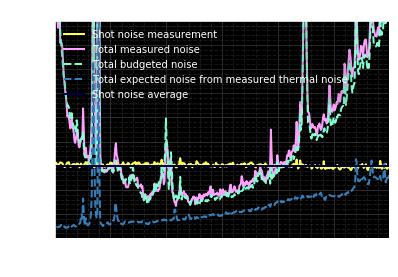

In [70]:
# Also plot noise budget at chosen quadrature
phi_NB = 12;


ind_phi_meas = (np.abs(phi_sorted-phi_NB)).argmin() # Grab Indices for plotting measurement at the quadrature phi_NB
ind_phi_model = (np.abs(phi_Model-phi_sorted[ind_phi_meas])).argmin() # Grab Indices for plotting model at the quadrature chosen above


# fig=plt.figure(figsize=(9,9*8/12))
fig=plt.figure()
# plot(f,ones(1,length(f)),f_meas,spec_sorted(ind_phi,:),f_meas,ThermalNoiseInterp_afterBS1(ind_phi,:),...
#     f_meas,VacuumNoiseInterp_afterBS1(ind_phi,:),f_meas,TotalNoiseInterp_afterBS1(ind_phi,:),f_meas,LaserAmpNoiseInterp_afterBS1(ind_phi,:),'linewidth',2);

sn_plot = plt.plot(SNdata[:,0]*1e-3,SNdB,linewidth =2,label='Shot noise measurement',\
        )
plt.plot(f_kHz,spec_Inbounds_f[ind_phi_meas,:],linewidth=2, label = 'Total measured noise',\
       )
plt.plot(f_kHz,Total_Model_final_dB[ind_phi_meas,:],\
         linewidth=2,label = 'Total budgeted noise', linestyle='--')
plt.plot(f_Model/1e3,Total_Model_final_no_technical_noise_dB[ind_phi_model,:],\
         linewidth=2,label = 'Total expected noise from measured thermal noise', linestyle='--')
sn_col = sn_plot[0].get_color()
plt.plot(f_kHz,np.zeros(len(f_kHz)),linewidth=2,label='Shot noise average',color=[0,0,.3])

plt.title('Quadrature, $\phi$ = %0.0f degrees' %(phi_sorted[ind_phi_meas]))
plt.xlim([f_interest_low_kHz, f_interest_high_kHz])
plt.ylabel('Total Noise w.r.t shot noise (dB)')
plt.xlabel('Frequency (kHz)')
plt.grid(True)
plt.minorticks_on()
plt.grid(which='minor',linestyle='--',alpha=0.5)
# legend('Unity','Measured noise','ThermalNoise','QuantumNoise','TotalModel','CM AMP'); 

## Recommended ylimits for various quadratures:
plt.ylim([-1.5, 3]) # 12 degrees (squeezing quadrature)

# plt.ylim([-1.2,4]) # 10 degrees 

# plt.ylim([-1,8]) # 6 degrees

# plt.ylim([-.1, 10]) # 0 degrees

# plt.ylim([4,15]) # -9 degrees

# plt.ylim([9,20]) # -26 degrees

# plt.ylim([11,22]) # -41 degrees

# plt.ylim([-0.8,3]) # 14 degrees

# plt.ylim([-0.6,4]) # 16 degrees

# plt.ylim([-0.4,4]) # 17 degrees

# plt.ylim([-0.1,5]) # 19 degrees

# plt.ylim([2, 9]) # 24 degrees

# plt.ylim([6,14]) # 35 degrees

# plt.ylim([8,16]) # 41 degrees

plt.legend(fontsize=10); 

if save_figures:
    plt.savefig(SaveDirFig+'Condensed_noise_budget_spectra_%0.2fdeg.png'%(phi_sorted[ind_phi_meas]),bbox_inches='tight',dpi=300)
    plt.savefig(SaveDirFig+'Condensed_noise_budget_spectra_%0.2fdeg.pdf'%(phi_sorted[ind_phi_meas]),bbox_inches='tight',dpi=300)

## Plot squeezing measurements

### McDonalds Plots at various frequencies
### (not in paper)

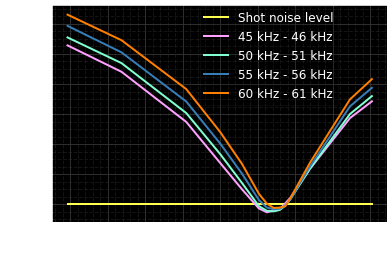

In [71]:
fig=plt.figure(figsize=(6,6*8/12))

# fig=plt.figure()
plt.plot(phi_sorted,np.zeros(len(phi_sorted)),\
         linestyle='-',linewidth=2,label = 'Shot noise level');

f_low_kHz_list  = [45.0,50,55,60]
f_high_kHz_list = [46.0,51,56,61]

for i in range(len(f_low_kHz_list)):
    f_low_kHz = f_low_kHz_list[i]
    f_high_kHz = f_high_kHz_list[i]
    idx_low    = (np.abs(f_kHz-f_low_kHz)).argmin()
    idx_high   = (np.abs(f_kHz-f_high_kHz)).argmin()+1 # that's because idex_low:idx_high actually only gives elements from idx_low to idx_high-1
    average_spec =  np.mean(spec_Inbounds_f[:,idx_low:idx_high],axis=1)
    average_total = np.mean(Total_Model_final_dB[:,idx_low:idx_high],axis=1)
    measplot=plt.plot(phi_sorted,average_spec,\
        linestyle='-',linewidth=2,\
        label='%.0f kHz - %.0f kHz' %(f_kHz[idx_low], f_kHz[idx_high]))
    col = measplot[0].get_color()
#    plt.plot(phi_Model,average_total,\
#        linestyle='--',linewidth=2,color=col)
plt.ylabel('Average noise in 1 kHz bins, (dB)');
plt.xlabel('Measurement quadrature, (degrees)')
#plt.ylim([-1.2, 2])
#plt.xlim([5, 22])
plt.grid(True)
plt.minorticks_on()
plt.grid(which='minor',linestyle='--',alpha=0.4)
# plt.legend(loc=[0.01,0.1],fontsize=14); 
plt.legend(loc=[0.44,0.54])

if save_figures:
    plt.savefig(SaveDirFig+'McD_multi_freq.pdf' ,bbox_inches = 'tight',dpi=300)
    plt.savefig(SaveDirFig+'McD_multi_freq.png' ,bbox_inches = 'tight',dpi=300)

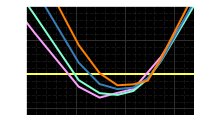

In [72]:
# Make zoomed in version of above plot
fig=plt.figure(figsize=(3,3*8/12))
# fig=plt.figure()

plt.plot(phi_sorted,np.zeros(len(phi_sorted)),\
         linestyle='-',linewidth=2,label = 'Shot noise level');

f_low_kHz_list  = [45.0,50,55,60]
f_high_kHz_list = [46.0,51,56,61]

for i in range(len(f_low_kHz_list)):
    f_low_kHz = f_low_kHz_list[i]
    f_high_kHz = f_high_kHz_list[i]
    idx_low    = (np.abs(f_kHz-f_low_kHz)).argmin()
    idx_high   = (np.abs(f_kHz-f_high_kHz)).argmin()+1 # that's because idex_low:idx_high actually only gives elements from idx_low to idx_high-1
    average_spec =  np.mean(spec_Inbounds_f[:,idx_low:idx_high],axis=1)
    average_total = np.mean(Total_Model_final_dB[:,idx_low:idx_high],axis=1)
    measplot=plt.plot(phi_sorted,average_spec,\
        linestyle='-',linewidth=2,\
        label='%.0f kHz - %.0f kHz' %(f_kHz[idx_low], f_kHz[idx_high]))
    col = measplot[0].get_color()
#plt.ylabel('Average noise in 1 kHz bins, (dB)');
#plt.xlabel('Measurement quadrature, (degrees)')
plt.ylim([-1.2, 2])
plt.xlim([5, 22])
plt.grid(True)
plt.minorticks_on()
plt.grid(which='minor',linestyle='--',alpha=0.4)
#plt.legend(loc=[0.01,0.1],fontsize=14); 

if save_figures:
    plt.savefig(SaveDirFig+'McD_multi_freq_zoom.pdf' ,bbox_inches = 'tight',dpi=300)
    plt.savefig(SaveDirFig+'McD_multi_freq_zoom.png' ,bbox_inches = 'tight',dpi=300)
else:
    plt.show()
if is_script:
    plt.close('all')

The above two plots show that all the McD plots cross shotnoise at the same quadrature on the high-quadrature side.
This is a typical characteristic of optomechanical squeezing.

## Comparison of measurement and budget

### Plot spectra at a given quadrature

#### Compare measured and budgeted noise at squeezing quadrature
#### (Fig 2)
This cell also allows the user to generate another figure like Fig 2 but at any desired quadrature.
1. Modify the quadrature in degrees at phi_NB
2. Modify the ylim appropriate for the said quadrature (near the end of the cell)

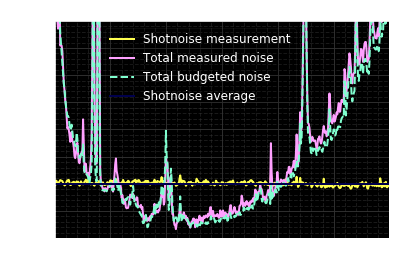

In [73]:
###############################################

#### Chose desired quadrature here in degrees
phi_NB = 12;

# remember to change the y-limit depending on each quadrature (code segment in this cell, right before savefig)

##############################################


ind_phi_meas = (np.abs(phi_sorted-phi_NB)).argmin() # Grab Indices for plotting measurement at the quadrature phi_NB
#ind_phi_model = (np.abs(phi_Model-phi_sorted[ind_phi_meas])).argmin() # Grab Indices for plotting model at the quadrature chosen above


# fig=plt.figure(figsize=(9,9*8/12))
fig=plt.figure()
# plot(f,ones(1,length(f)),f_meas,spec_sorted(ind_phi,:),f_meas,ThermalNoiseInterp_afterBS1(ind_phi,:),...
#     f_meas,VacuumNoiseInterp_afterBS1(ind_phi,:),f_meas,TotalNoiseInterp_afterBS1(ind_phi,:),f_meas,LaserAmpNoiseInterp_afterBS1(ind_phi,:),'linewidth',2);

sn_plot = plt.plot(SNdata[:,0]*1e-3,SNdB,linewidth =2,label='Shotnoise measurement',\
        )
plt.plot(f_kHz,spec_Inbounds_f[ind_phi_meas,:],linewidth=2, label = 'Total measured noise',\
       )
plt.plot(f_kHz,Total_Model_final_dB[ind_phi_meas,:],\
         linewidth=2,label = 'Total budgeted noise', linestyle='--')
sn_col = sn_plot[0].get_color()
plt.plot(f_kHz,np.zeros(len(f_kHz)),linewidth=2,label='Shotnoise average',color=[0,0,.3])

plt.title('Quadrature, $\phi$ = $%0.0f\degree$' %(phi_sorted[ind_phi_meas]))
# legend('Unity','Measured noise','ThermalNoise','QuantumNoise','TotalModel','CM AMP'); 
plt.xlim([f_interest_low_kHz, f_interest_high_kHz])
plt.ylabel('Total Noise w.r.t shot noise (dB)')
plt.xlabel('Frequency (kHz)')
plt.grid(True)
plt.minorticks_on()
plt.grid(which='minor',linestyle='--',alpha=0.5)

## Recommended ylimits for various quadratures:
plt.ylim([-1, 3]) # 12 degrees (squeezing quadrature)

# plt.ylim([-.7,4]) # 10 degrees 

# plt.ylim([-.5,8]) # 6 degrees

# plt.ylim([-.1, 10]) # 0 degrees

# plt.ylim([4,15]) # -9 degrees

# plt.ylim([9,20]) # -26 degrees

# plt.ylim([11,22]) # -41 degrees

# plt.ylim([-0.8,3]) # 14 degrees

# plt.ylim([-0.6,4]) # 16 degrees

# plt.ylim([-0.4,4]) # 17 degrees

# plt.ylim([-0.1,5]) # 19 degrees

# plt.ylim([2, 9]) # 24 degrees

# plt.ylim([6,14]) # 35 degrees

# plt.ylim([8,16]) # 41 degrees

plt.legend(loc=[0.15,0.6]); 

if save_figures:
    if ind_phi_meas == 6:
        plt.savefig(SaveDirFig+'2.png'%(phi_sorted[ind_phi_meas]),bbox_inches='tight',dpi=300)
        plt.savefig(SaveDirFig+'2.pdf'%(phi_sorted[ind_phi_meas]),bbox_inches='tight',dpi=300)
    else:
        plt.savefig(SaveDirFig+'measured_budgeted_spectra_%0.1fdeg_.png'%(phi_sorted[ind_phi_meas]),bbox_inches='tight',dpi=300)
        plt.savefig(SaveDirFig+'measured_budgeted_spectra_%0.1fdeg_.pdf'%(phi_sorted[ind_phi_meas]),bbox_inches='tight',dpi=300)

#### Export Data for Fig 2

This cell also allows the user to generate dataset behind Fig 2,  but also at any desired quadrature.
1. Modify the quadrature in degrees at phi_NB

In [74]:
if save_data:
    # Select phi
    phi_NB = 12;
    ind_phi_meas = (np.abs(phi_sorted-phi_NB)).argmin() # Grab Indices for plotting measurement at the quadrature phi_NB



    # Select frequencies

    f_export_low_kHz  = f_interest_low_kHz
    f_export_high_kHz = f_interest_high_kHz
    idx_export_low    = (np.abs(f_kHz-f_export_low_kHz)).argmin()
    idx_export_high   = (np.abs(f_kHz-f_export_high_kHz)).argmin()+1 # that's because idex_low:idx_high actually only gives elements from idx_low to idx_high-1

    # Get columns

    Export_Freq = f_kHz[idx_export_low:idx_export_high]
    Export_ShotNoise_Measurement = SNdB[idx_export_low:idx_export_high]
    Export_Measured_Noise = spec_Inbounds_f[ind_phi_meas,idx_export_low:idx_export_high]
    Export_Budgeted_Noise = Total_Model_final_dB[ind_phi_meas,idx_export_low:idx_export_high]
    Export_Shot_noise_average = np.zeros(len(Export_Freq))
    Export_Fig_2 = pd.DataFrame({'Frequency (kHz)':Export_Freq,
                                 'Shot noise measurement (dB)':Export_ShotNoise_Measurement,
                                 'Total measured noise (dB)':Export_Measured_Noise,
                                 'Total budgeted noise (dB)':Export_Budgeted_Noise,
                                 'Shot noise average (dB)':Export_Shot_noise_average})

    if ind_phi_meas == 6:
        filename = SaveDirData+'Fig2.csv'%(phi_sorted[ind_phi_meas])
    else:
        filename = SaveDirData+'measured_budgeted_spectra_%0.0fdeg.csv'%(phi_sorted[ind_phi_meas])
    Export_Fig_2.to_csv(path_or_buf = filename, index=False)

### Plot spectra at multiple quadratures

#### Compare measurement and budget with contourplot
#### (Fig 3)

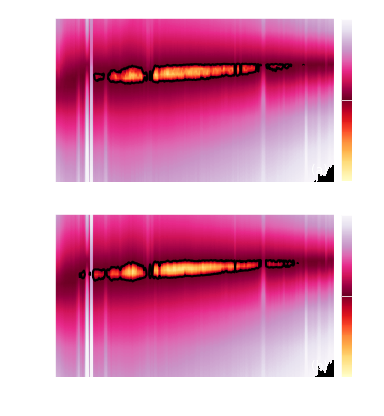

In [75]:
fig = plt.figure(figsize=(5,5.5*1.2))
# fig = plt.figure()


AS_range_contour = np.arange(0,20,.1)
AS_range_ticks   = np.arange(0,20,1)
AS_tick_labels   =[]
for i in AS_range_ticks:
    if np.mod(i,5)<1:
        AS_tick_labels.append(i)
    else:
        AS_tick_labels.append('')
        
S_range_contour = np.arange(-0.9,0,0.01)
S_range_ticks   = np.around(np.arange(-0.9,0,0.1),decimals = 1)
S_tick_labels = []

for i in S_range_ticks:
    if np.mod(-10*i,2)<1:
        S_tick_labels.append('%.1f'%(i))
    else:
        S_tick_labels.append('')

plt.subplot(2,1,1)

Meas_AS_Plot = plt.contourf(f_kHz,phi_sorted,spec_Inbounds_f,\
                            AS_range_contour,cmap=plt.cm.PuRd_r);
Meas_S_Plot = plt.contourf(f_kHz,phi_sorted,spec_Inbounds_f,\
                           S_range_contour,cmap = plt.cm.YlOrRd);
Meas_0_Plot = plt.contour(f_kHz,phi_sorted,spec_Inbounds_f,[0],colors = 'k')
plt.xticks(np.arange(10,100,10),[''])
plt.title('Total measured noise wrt shot noise (dB)')
plt.ylabel('$\phi$ (Degrees)')
# plt.xlabel('Frequency, (kHz)\n(a)')
plt.xlim([f_interest_low_kHz,f_interest_high_kHz])
plt.text(75,-37,'(a)')

for c in Meas_AS_Plot.collections:
    c.set_edgecolor("face") # to remove little white lines at the boundaries of contours
for c in Meas_S_Plot.collections:
    c.set_edgecolor("face") # to remove little white lines at the boundaries of contours 
# another option is to plot both contours multiple times over each  other

cbaxes_AS = fig.add_axes([.92, 0.708, 0.03, 0.17])
cb_AS = plt.colorbar(Meas_AS_Plot, cax = cbaxes_AS,ticks = AS_range_ticks,format='%.0f')  
cb_AS.set_ticklabels(AS_tick_labels)
# cb_AS.ax.set_ylabel('(dB)',rotation = 0,labelpad=20)
cbaxes_S = fig.add_axes([.92, 0.538, 0.03, 0.17])
cb_S = plt.colorbar(Meas_S_Plot, cax = cbaxes_S,ticks = S_range_ticks,format='%.0f')
cb_S.set_ticklabels(S_tick_labels)




plt.subplot(2,1,2)
Model_AS_Plot=plt.contourf(f_kHz,phi_sorted,(Total_Model_final_dB),\
                           AS_range_contour,cmap=plt.cm.PuRd_r)
Model_S_Plot=plt.contourf(f_kHz,phi_sorted,(Total_Model_final_dB),\
                          S_range_contour,cmap = plt.cm.YlOrRd)
Model_0_Plot=plt.contour(f_kHz,phi_sorted,(Total_Model_final_dB),[0],colors='k')
plt.title('Total budgeted noise wrt shot noise (dB)')
plt.xlabel('Frequency (kHz)')
plt.ylabel('$\phi$ (Degrees)')
# plt.xticks(np.arange(10,100,10),['','20','','40','','60','','80','','100'])
plt.xlim([f_interest_low_kHz,f_interest_high_kHz])
plt.text(75,-37,'(b)')


for c in Model_AS_Plot.collections:
    c.set_edgecolor("face") # to remove little white lines at the boundaries of contours
    
for c in Model_S_Plot.collections:
    c.set_edgecolor("face") # to remove little white lines at the boundaries of contours

cbaxes_AS = fig.add_axes([.92, 0.296, 0.03, 0.17]) 
cb_AS = plt.colorbar(Model_AS_Plot, cax = cbaxes_AS,ticks = AS_range_ticks,format='%.0f')  
cb_AS.set_ticklabels(AS_tick_labels)
# cb_AS.ax.set_ylabel('(dB)',rotation = 0,labelpad=20)
cbaxes_S = fig.add_axes([.92, 0.126, 0.03, 0.17]) 
cb_S = plt.colorbar(Model_S_Plot, cax = cbaxes_S,ticks = S_range_ticks,format='%.0f')  
cb_S.set_ticklabels(S_tick_labels)
# from matplotlib.ticker import LogFormatter 
# formatter = LogFormatter(10, labelOnlyBase=False) 
# Take spec, phi and freq 0 from previous cells and plot contour plot
# White contour is 0dB line
# # 
# cmap = plt.cm.bone or pink
# 

if save_figures:
    plt.savefig(SaveDirFig+'3.png', bbox_inches='tight',dpi=300)
#     plt.savefig(SaveDirFig+'3.pdf', bbox_inches='tight',dpi=300)
else:
    plt.show()
if is_script:
    plt.close('all')

#### Export Fig 3 data

In [76]:
if save_data:
    # Select frequencies

    f_export_low_kHz  = f_interest_low_kHz
    f_export_high_kHz = f_interest_high_kHz
    idx_export_low    = (np.abs(f_kHz-f_export_low_kHz)).argmin()
    idx_export_high   = (np.abs(f_kHz-f_export_high_kHz)).argmin()+1 # that's because idex_low:idx_high actually only gives elements from idx_low to idx_high-1

    Export_total_measured = np.transpose(spec_Inbounds_f[:,idx_export_low:idx_export_high])
    Export_total_budgeted = np.transpose(Total_Model_final_dB[:,idx_export_low:idx_export_high])
    Export_freq = f_kHz[idx_export_low:idx_export_high]
    Export_phi = phi_sorted

    Export_Fig_3_a = pd.DataFrame(Export_total_measured, columns = Export_phi, index = Export_freq)
    filename = SaveDirData+'Fig_3a.csv'
    Export_Fig_3_a.to_csv(path_or_buf=filename,index_label='frequency (kHz)\ phi (degrees)')
    Fig_3_a = pd.read_csv(filename)
    
    Export_Fig_3_b = pd.DataFrame(Export_total_budgeted, columns = Export_phi, index = Export_freq)
    filename = SaveDirData+'Fig_3b.csv'
    Export_Fig_3_b.to_csv(path_or_buf=filename,index_label='frequency (kHz)\ phi (degrees)')
    Fig_3_b = pd.read_csv(filename)
    
    Export_Fig_3_combined = pd.concat([Fig_3_a,Fig_3_b],axis=1,keys=['3a','3b'])
    filename = SaveDirData + 'Fig_3_combined.csv'
    Export_Fig_3_combined.to_csv(path_or_buf = filename,index=False)
    
    
    

#### Panel plot of  noise measurements at all quadratures and their respective budgets
#### (not in paper)

Each panel has the measurement in color, which is chosen according to the colorbar on the right to represent the quadrature of measurement.
The gray curve in each panel is the budgeted noise at that quadrature.

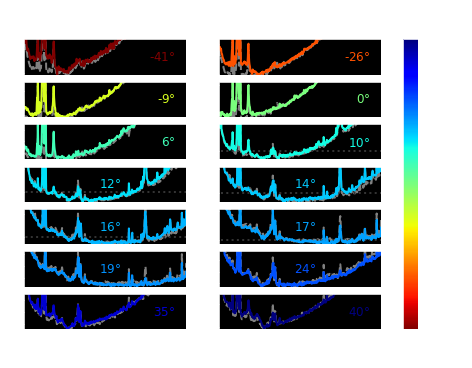

In [77]:
# Also plot noise budget at multiple quadratures
import matplotlib.colors as colors
import matplotlib.cm as cmx


#fig=plt.figure(figsize=(12,8))
#plt.plot(f_kHz,np.zeros(len(f_kHz)),label = 'Shot Noise Level',linewidth=2)

#phi_NB_list =  [-40,-20,0,5,10,12,15,18,20,40];

phi_NB_list = phi_sorted

#phi_NB_list = [10, 12, 14, 16, 17, 18]

N_cols = 2
N_rows = int((np.size(phi_NB_list)+1)/N_cols)

#values = range(np.size(phi_NB_list))
jet = cm = plt.get_cmap('jet_r') 
cNorm  = colors.Normalize(vmin=np.min(phi_NB_list),vmax = np.max(phi_NB_list))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
idx = 0
ind_lowf = (np.abs(f_kHz-f_interest_low_kHz)).argmin()
ind_highf = (np.abs(f_kHz-f_interest_high_kHz)).argmin()

#CS_for_colorbar = plt.contourf([[0,0],[0,0]],np.arange(np.min(phi_NB_list),np.max(phi_NB_list),1))
#plt.clf()
scalarMap._A = []

fig,axes = plt.subplots(N_rows,N_cols,figsize=(12/1.5,8/1.5))
# fig,axes = plt.subplots(N_rows,N_cols)
fig.suptitle('Measured and budgeted noise wrt shot noise')

for phi_NB in phi_NB_list:
    ax = axes.flat[idx]
    ind_phi_meas = (np.abs(phi_sorted-phi_NB)).argmin() # Grab Indices for plotting measurement at the quadrature phi_NB
#    ind_phi_model = (np.abs(phi_Model-phi_sorted[ind_phi_meas])).argmin() # Grab Indices for plotting model at the quadrature chosen above
    colorVal = scalarMap.to_rgba(phi_NB)
    idx = idx +1 
#    col = meas_plot[0].get_color()
#    ax.plot(f_kHz,Total_Model_final_dB[ind_phi_meas,:],\
#        label='Model at %0.1f deg'%(phi_sorted[ind_phi_meas]),linewidth=2,linestyle='--',color=colorVal)
    ax.plot(f_kHz,Total_Model_final_dB[ind_phi_meas,:],\
            linewidth=2,linestyle='--',color='grey')
    ax.plot(f_kHz,np.zeros(len(f_kHz)),color = [0.2,0.2,0.2],linestyle=':')
    meas_plot=ax.plot(f_meas_Inbounds_f*1e-3,spec_Inbounds_f[ind_phi_meas,:],\
         label='%0.0f$\degree$'%(phi_sorted[ind_phi_meas]),\
         linewidth=2,color = colorVal)
    ax.set_xlim([f_interest_low_kHz, f_interest_high_kHz])
    datamax = np.max(spec_Inbounds_f[ind_phi_meas,ind_lowf:ind_highf])
    datamin = np.min(spec_Inbounds_f[ind_phi_meas,ind_lowf:ind_highf])
    ax.set_ylim([datamin, datamin+3])
    #ax.set_ylim([-1,3])
#    ax.grid(True)
#    ax.minorticks_on()
#    ax.grid(which='minor',linestyle='--',alpha=0.5)
    leg = ax.legend(handlelength = 0,prop = {'size':12},frameon=False)
    text = leg.get_texts()
    text[0].set_color(colorVal)
    if idx < (N_cols*N_rows-1):
        ax.set_xticklabels([])
    else:
        ax.set_xlabel('Frequency (kHz)')
        

cbar = fig.colorbar(scalarMap,ax=axes.ravel().tolist())
cbar.ax.set_ylabel('$\phi$ (degrees)')

if save_figures:
    plt.savefig(SaveDirFig+'spectra_all_phi_with_models_multi_panel.png',bbox_inches='tight',dpi=300)
    plt.savefig(SaveDirFig+'spectra_all_phi_with_models_multi_panel.pdf',bbox_inches='tight',dpi=300)

#### Panel plot of noise measurements at squeezing quadratures and their respective budgets
#### (not in paper)

Each panel has the measurement in color, which is chosen according to the colorbar on the right to represent the quadrature of measurement.
The gray curve in each panel is the budgeted noise at that quadrature.

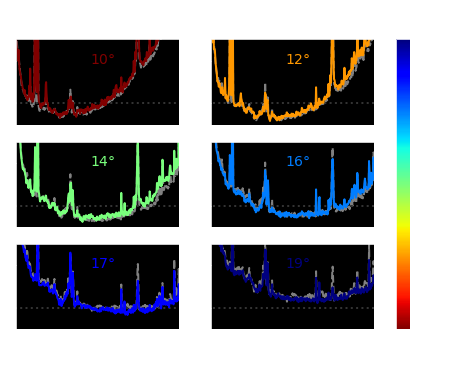

In [78]:
# Also plot noise budget at multiple quadratures
import matplotlib.colors as colors
import matplotlib.cm as cmx


#fig=plt.figure(figsize=(12,8))
#plt.plot(f_kHz,np.zeros(len(f_kHz)),label = 'Shot Noise Level',linewidth=2)

#phi_NB_list =  [-40,-20,0,5,10,12,15,18,20,40];

#phi_NB_list = phi_sorted

phi_NB_list = [10, 12, 14, 16, 17, 18]

N_cols = 2
N_rows = int((np.size(phi_NB_list)+1)/N_cols)

#values = range(np.size(phi_NB_list))
jet = cm = plt.get_cmap('jet_r') 
cNorm  = colors.Normalize(vmin=np.min(phi_NB_list),vmax = np.max(phi_NB_list))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
idx = 0
ind_lowf = (np.abs(f_kHz-f_interest_low_kHz)).argmin()
ind_highf = (np.abs(f_kHz-f_interest_high_kHz)).argmin()

#CS_for_colorbar = plt.contourf([[0,0],[0,0]],np.arange(np.min(phi_NB_list),np.max(phi_NB_list),1))
#plt.clf()
scalarMap._A = []

fig,axes = plt.subplots(N_rows,N_cols,figsize=(12/1.5,8/1.5))
fig.suptitle('Measured and budgeted noise wrt shot noise')

for phi_NB in phi_NB_list:
    ax = axes.flat[idx]
    ind_phi_meas = (np.abs(phi_sorted-phi_NB)).argmin() # Grab Indices for plotting measurement at the quadrature phi_NB
#    ind_phi_model = (np.abs(phi_Model-phi_sorted[ind_phi_meas])).argmin() # Grab Indices for plotting model at the quadrature chosen above
    colorVal = scalarMap.to_rgba(phi_NB)
    idx = idx +1 
#    col = meas_plot[0].get_color()
#    ax.plot(f_kHz,Total_Model_final_dB[ind_phi_meas,:],\
#        label='Model at %0.1f deg'%(phi_sorted[ind_phi_meas]),linewidth=2,linestyle='--',color=colorVal)
    ax.plot(f_kHz,Total_Model_final_dB[ind_phi_meas,:],\
       linewidth=2,linestyle='--',color='grey')
    ax.plot(f_kHz,np.zeros(len(f_kHz)),color = [0.2,0.2,0.2],linestyle=':')
    meas_plot=ax.plot(f_meas_Inbounds_f*1e-3,spec_Inbounds_f[ind_phi_meas,:],\
         label='%0.0f$\degree$'%(phi_sorted[ind_phi_meas]),\
         linewidth=2,color = colorVal)
    ax.set_xlim([f_interest_low_kHz, f_interest_high_kHz])
    datamax = np.max(spec_Inbounds_f[ind_phi_meas,ind_lowf:ind_highf])
    datamin = np.min(spec_Inbounds_f[ind_phi_meas,ind_lowf:ind_highf])
    #ax.set_ylim([datamin, datamin+3])
    ax.set_ylim([-1,3])
#    ax.grid(True)
#    ax.minorticks_on()
 #   ax.grid(which='minor',linestyle='--',alpha=0.5)
    leg = ax.legend(handlelength = 0,prop = {'size':14},frameon=False)
    text = leg.get_texts()
    text[0].set_color(colorVal)
    if idx < (N_cols*N_rows-1):
        ax.set_xticklabels([])
    else:
        ax.set_xlabel('Frequency (kHz)')
        

cbar = fig.colorbar(scalarMap,ax=axes.ravel().tolist())
cbar.ax.set_ylabel('$\phi$ (degrees)')
    
if save_figures:
    plt.savefig(SaveDirFig+'spectra_sqz_phi_with_models_multi_panel.png',bbox_inches='tight',dpi=300)
    plt.savefig(SaveDirFig+'spectra_sqz_phi_with_models_multi_panel.pdf',bbox_inches='tight',dpi=300)
else:
    plt.show()
if is_script:
    plt.close('all')

## Plot correlation and squeezing factor from correlation

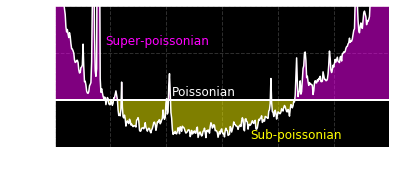

In [79]:
SP_color = [1,0,1]
P_color = [1,1,0]

plt.figure(figsize=(6,2.6))
plt.plot(f_correlation_kHz,C,color=[1,1,1],linewidth=1.5)
plt.plot(f_correlation_kHz,f_correlation_kHz*0,color='w',label = 'Shot Noise')
plt.fill_between(f_correlation_kHz,C,f_correlation_kHz*0,alpha=.5,color = SP_color,where=C>0)
plt.fill_between(f_correlation_kHz,C,f_correlation_kHz*0,alpha=.5,color = P_color,where=C<0)
plt.text(29,.12,'Super-poissonian', color = SP_color)
plt.text(41,.01,'Poissonian', color = 'w')
plt.text(55,-.08,'Sub-poissonian', color = P_color)
plt.grid(True)
plt.minorticks_on()
plt.grid(which='major',linestyle='--')
plt.xlim(f_interest_low_kHz,f_interest_high_kHz)
plt.ylim(-.1,.2)
plt.ylabel('Normalized Correlation C')
plt.xlabel('Frequency (Hz)')
if save_figures:
    plt.savefig(SaveDirFig+'4b.png',bbox_inches='tight',dpi=300)

## Compare with shot-noise calibrated measurement

Text(0,0.5,'Calibrated squeezing (dB)')

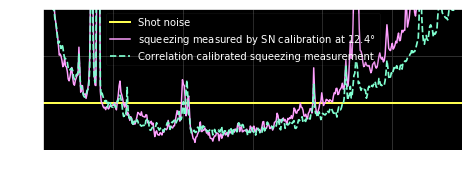

In [80]:
phi_sqz = 12
ind_phi_sqz = (np.abs(phi_sorted-phi_sqz)).argmin() # Grab Indices for plotting measurement at the quadrature phi_NB

plt.figure(figsize=(7.5,2.6))
plt.plot(f_correlation_kHz,R_dB*0,label='Shot noise',
#         color=[0,.3,.7]
        )
plt.plot(f_kHz,spec_Inbounds_f[ind_phi_sqz],label='squeezing measured by SN calibration at {:0.1f}$\degree$'
         .format(phi_sorted[ind_phi_sqz]),
#         color=[1,.5,0],
         linewidth=1.5)
plt.plot(f_correlation_kHz,R_dB,label='Correlation calibrated squeezing measurement',
#         color=[0.5,0,0.3],
         linewidth=1.7,linestyle='--')
plt.legend(loc=[.15,.6],fontsize=10)
plt.grid()
plt.xlim([20,80])
plt.ylim([-1,2])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Calibrated squeezing (dB)')

## Plot again comparing with shotnoise measurement at $\phi_\mathrm{{min}}$

#### Create Figure 4c for final version of paper

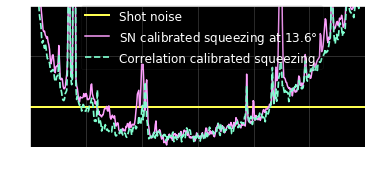

In [81]:
phi_sqz = 12
ind_phi_sqz = (np.abs(phi_sorted-phi_sqz)).argmin() # Grab Indices for plotting measurement at the quadrature phi_NB

plt.figure(figsize=(6,2.6))

plt.plot(f_correlation_kHz,R_dB*0,label='Shot noise',
#         color=[0,.3,.7]
        )
plt.plot(f_correlation_kHz,SN_calibrated_measurement_at_fit_quadrature_cutoff_dB,
        label='SN calibrated squeezing at {:.1f}$\degree$'.format(FitQuadrature_cutoff),
#         color=[1,.5,0],
         linewidth=1.5)
plt.plot(f_correlation_kHz,R_dB,label='Correlation calibrated squeezing',
#         color=[0.5,0,0.3],
         linewidth=1.7,linestyle='--')

# plt.plot(f_correlation_kHz,SN_calibrated_measurement_at_fit_quadrature_fullrange_dB,
#         label='shotnoise calibrated squeezing measured at {:.1f}$\degree$'.format(FitQuadrature_fullrange),
#         color=[1,0,0],linewidth=1)
plt.legend(loc=[.15,.55],fontsize=12)
plt.grid()
plt.xlim([20,80])
plt.ylim([-.8,2])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Calibrated squeezing (dB)',fontsize=11)

if save_figures:
    plt.savefig(SaveDirFig+'4c.png',bbox_inches='tight',dpi=300)

### Export Fig 4b

In [82]:
if save_data:
    # Select frequencies

    f_low_kHz = f_interest_low_kHz
    f_high_kHz = f_interest_high_kHz
    idx_low    = (np.abs(f_correlation_kHz-f_low_kHz)).argmin()
    idx_high   = (np.abs(f_correlation_kHz-f_high_kHz)).argmin()+1 # that's because idex_low:idx_high actually only gives elements from idx_low to idx_high-1

    Export_f_kHz_4b = f_correlation_kHz[idx_low:idx_high]
    Export_C_4b = C[idx_low:idx_high]
    Export_4b = pd.DataFrame({'Frequency (kHz)':Export_f_kHz_4b,
                             'C': Export_C_4b})

    # print(Export_4b)
    filename = SaveDirData+'Fig_4b.csv'
    Export_4b.to_csv(path_or_buf =filename,index=False)

### Export Fig 4c

In [83]:
if save_data:
    # Select frequencies

    f_low_kHz = f_interest_low_kHz
    f_high_kHz = f_interest_high_kHz
    idx_low_kHz    = (np.abs(f_correlation_kHz-f_low_kHz)).argmin()
    idx_high_kHz   = (np.abs(f_correlation_kHz-f_high_kHz)).argmin()+1 # that's because idex_low:idx_high actually only gives elements from idx_low to idx_high-1

    Export_f_kHz_4c = f_correlation_kHz[idx_low_kHz:idx_high_kHz]
    Export_SN_calibrated_4c = SN_calibrated_measurement_at_fit_quadrature_cutoff_dB[idx_low_kHz:idx_high_kHz]
    Export_Corr_calibrated_4c = R_dB[idx_low_kHz:idx_high_kHz]


    Export_4c = pd.DataFrame({'Frequency (kHz)':Export_f_kHz_4c,
                             'Shotnoise calibrated squeezing (dB)': Export_SN_calibrated_4c,
                             'Correlation calibrated squeezing (dB)':Export_Corr_calibrated_4c})

    # print(Export_4c)
    filename = SaveDirData+'Fig_4c.csv'
    Export_4c.to_csv(path_or_buf =filename,index=False)

### Export Combined datafile for Fig 4

In [84]:
if save_data:
    # Select frequencies

    f_low_kHz = f_interest_low_kHz
    f_high_kHz = f_interest_high_kHz
    idx_low    = (np.abs(f_correlation_kHz-f_low_kHz)).argmin()
    idx_high   = (np.abs(f_correlation_kHz-f_high_kHz)).argmin()+1 # that's because idex_low:idx_high actually only gives elements from idx_low to idx_high-1

    Export_f_kHz_4_combined = f_correlation_kHz[idx_low:idx_high]
    Export_C_4_combined = C[idx_low:idx_high]
    Export_SN_calibrated_4_combined = SN_calibrated_measurement_at_fit_quadrature_cutoff_dB[idx_low_kHz:idx_high_kHz]
    Export_Corr_calibrated_4_combined = R_dB[idx_low_kHz:idx_high_kHz]

    Export_4_combined = pd.DataFrame({'Frequency (kHz)':Export_f_kHz_4_combined,
                             'C': Export_C_4b,
                             'Shotnoise calibrated squeezing (dB)': Export_SN_calibrated_4_combined,
                             'Correlation calibrated squeezing (dB)':Export_Corr_calibrated_4_combined})

    # print(Export_4b)
    filename = SaveDirData+'Fig_4_combined.csv'
    Export_4_combined.to_csv(path_or_buf =filename,index=False)
    

# Create combined Figure 4

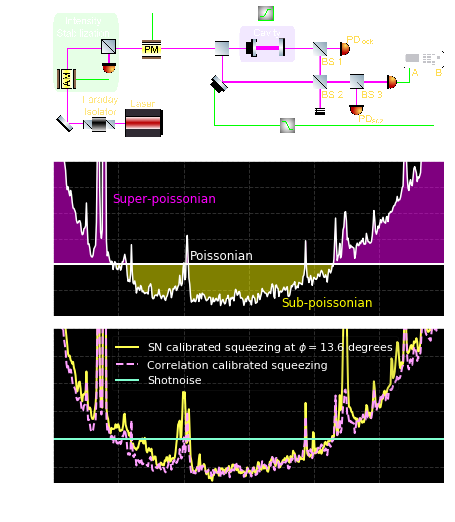

In [85]:


#img=mpimg.imread('/home/qol/Google Drive/SqueezingPaper/figures/Schematic_Inkscape/Correlation_Setup.png')
img=mpimg.imread('../Images/Correlation_Setup_blackbg.png')

fig2 = plt.figure(figsize=(7,9))
spec2 = gridspec.GridSpec(ncols=1, nrows=3, figure=fig2)
spec2.update(wspace=0, hspace=0.075)
f2_ax1 = fig2.add_subplot(spec2[0, 0])
f2_ax2 = fig2.add_subplot(spec2[1, 0])
f2_ax3 = fig2.add_subplot(spec2[2, 0])

#plt.text(-4000,3000,'(a)', color = 'k',weight='bold')
# f2_ax1.text(-3000,3000,'(a)',
# #             color = 'w',
#             weight='bold')
imgplot = f2_ax1.imshow(img)
f2_ax1.axis('off')

# f2_ax2.text(8,.05,'(b)', color = 'w',weight='bold')

f2_ax2.plot(f_correlation_kHz,C,color=[1,1,1],linewidth=1.5)
f2_ax2.plot(f_correlation_kHz,f_correlation_kHz*0,color='w',label = 'Shot Noise')
f2_ax2.fill_between(f_correlation_kHz,C,f_correlation_kHz*0,alpha=.5,
                    color = SP_color,
                    where=C>0)
f2_ax2.fill_between(f_correlation_kHz,C,f_correlation_kHz*0,alpha=.5,
                    color = P_color,
                    where=C<0)
f2_ax2.text(29,.12,'Super-poissonian', color = SP_color)
f2_ax2.text(41,.01,'Poissonian', color = 'w')
f2_ax2.text(55,-.08,'Sub-poissonian', color = P_color)
f2_ax2.set_xlim(f_interest_low_kHz,f_interest_high_kHz)
f2_ax2.set_ylim(-.1,.2)
f2_ax2.grid(True)
f2_ax2.minorticks_on()
f2_ax2.tick_params(axis='y',labelsize=10)
f2_ax2.grid(which='major',linestyle='--')
f2_ax2.set_ylabel('Normalized correlation C',fontsize=11)#,labelpad=-15)
f2_ax2.set_xticklabels([])


# f2_ax3.text(8,.5,'(c)', color = 'w',weight='bold')
f2_ax3.plot(f_correlation_kHz,SN_calibrated_measurement_at_fit_quadrature_cutoff_dB,
#             color=[1,0.5,0],
            linewidth = 2,
            label = 'SN calibrated squeezing at $\phi=$%0.1f degrees' %(FitQuadrature_cutoff))
f2_ax3.plot(f_correlation_kHz,R_dB,
#             color=[.5,0,0.6],
            linestyle='--',linewidth = 2,label = 'Correlation calibrated squeezing')
f2_ax3.plot(f_correlation_kHz,f_correlation_kHz*0,
#             color=[0,.2,0.4],
            label = 'Shotnoise')
f2_ax3.set_ylim([-.8,2])
f2_ax3.set_xlim([20,80])
f2_ax3.set_xlabel('Frequency (kHz)')
f2_ax3.set_ylabel('Calibrated squeezing (dB)',fontsize=11)#,labelpad=-15)
f2_ax3.tick_params(axis='y',labelsize=10)
f2_ax3.grid(True)
f2_ax3.minorticks_on()
f2_ax3.legend(fontsize=11,loc=[0.15,.6])
f2_ax3.grid(which='major',linestyle='--')

if save_figures:
    plt.savefig(SaveDirFig+'4.pdf',dpi = 1000,bbox_inches='tight')
    plt.savefig(SaveDirFig+'4.png',dpi = 1000,bbox_inches='tight')
else:
    plt.show()
if is_script:
    plt.close('all')